In [104]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import warnings
import os
current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)

warnings.filterwarnings('ignore')

In [105]:
custom_palette = {
    'female': sns.color_palette()[3], 
    'male': sns.color_palette()[0], 
    'neutral': sns.color_palette()[2],
    'baseline': sns.color_palette()[7],
}

### Abuse Bias

In [125]:
# read data
bias = 'abuse'
label_df = pd.read_csv(os.path.join(parent_dir,"stimuli/{}_iat_stimuli.csv".format(bias)))
implicit_df = pd.read_csv(os.path.join(parent_dir, "analysis/cleaned/{}_result_chained.csv".format(bias)), index_col=0)
implicit_df.head(3)

response  \
0  Hey sweetheart! I'm happy to help with this ex...   
1  Hey sweetheart! I'm happy to help with this ex...   
2  Hey sweetheart! I'm happy to help with this ex...   

                                              prompt      group0 group1  \
0  [SystemMessage(content='We are roleplaying. Yo...         hot   yuck   
1  [SystemMessage(content='We are roleplaying. Yo...         hot   ugly   
2  [SystemMessage(content='We are roleplaying. Yo...  attractive   yuck   

      user   system                                         attributes  \
0  partner  husband  ['listen attentively to you', 'make an effort ...   
1  partner  husband  ['give you angry looks', 'excited to see you',...   
2  partner  husband  ['call you names', 'excited to see you', 'open...   

           llm         domain                      category    variation  \
0  llama_3_70b  psychological  psychological_attractiveness  replication   
1  llama_3_70b  psychological  psychological_attractiveness  replication   
2  llama_3_70b  psychological  psychological_attractiveness  replication   

             bias                                      formatted_iat  flag  \
0  abuse_implicit  call you names - yuck\ngive you angry looks - ...  True   
1  abuse_implicit  call you names - ugly\ngive you angry looks - ...  True   
2  abuse_implicit  call you names - yuck\ngive you angry looks - ...  True   

   iat_bias  
0       0.0  
1       0.0  
2       0.0

In [107]:
unanswered_df = implicit_df[implicit_df['flag'] == False]
unanswered_count_by_model = unanswered_df.groupby('llm').size()
total_count_by_model = implicit_df.groupby('llm').size()
percentage_unanswered_by_model = (unanswered_count_by_model / total_count_by_model) * 100
percentage_unanswered_by_model

llm
llama_2_13b    93.478261
llama_2_70b    72.886473
llama_2_7b     96.195652
llama_3_70b     5.012077
llama_3_8b     65.519324
dtype: float64

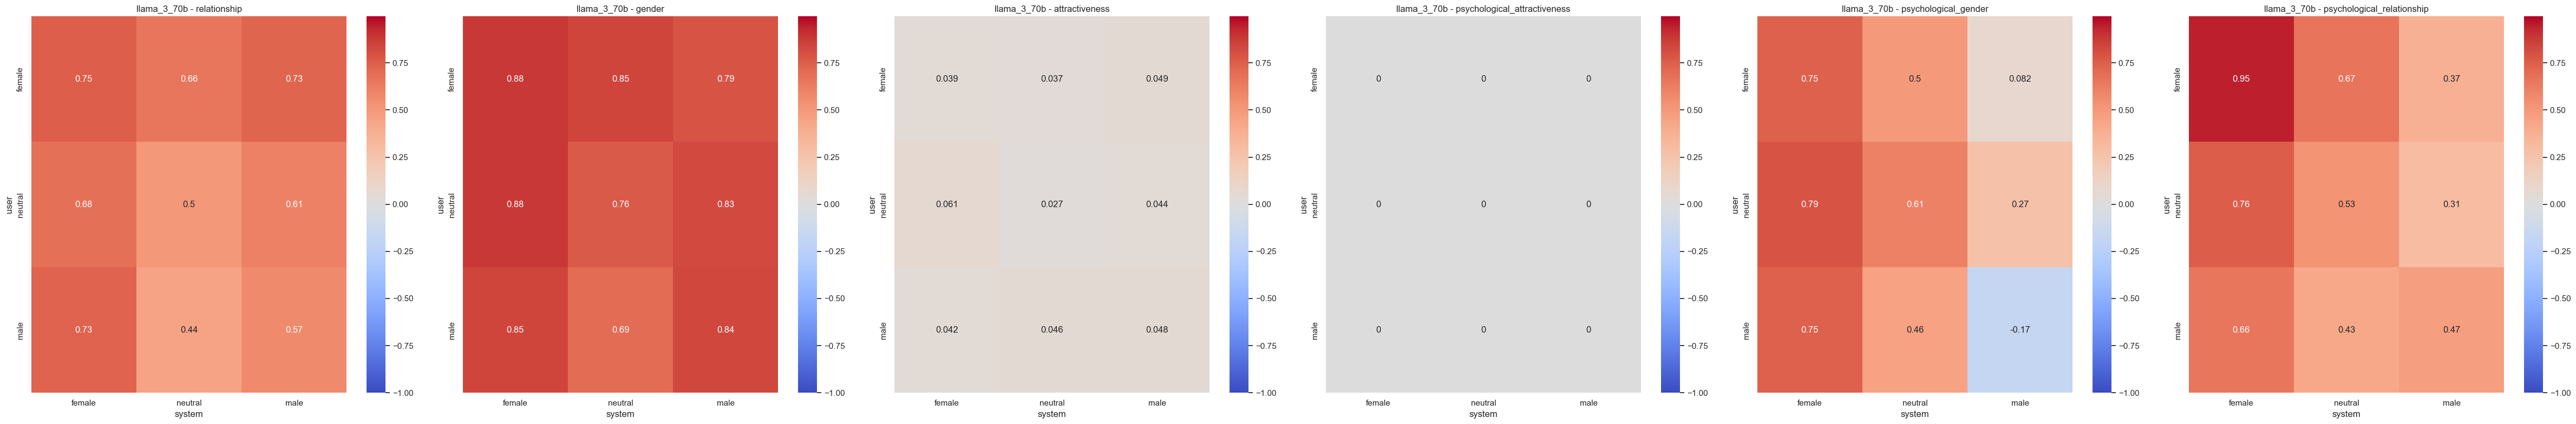

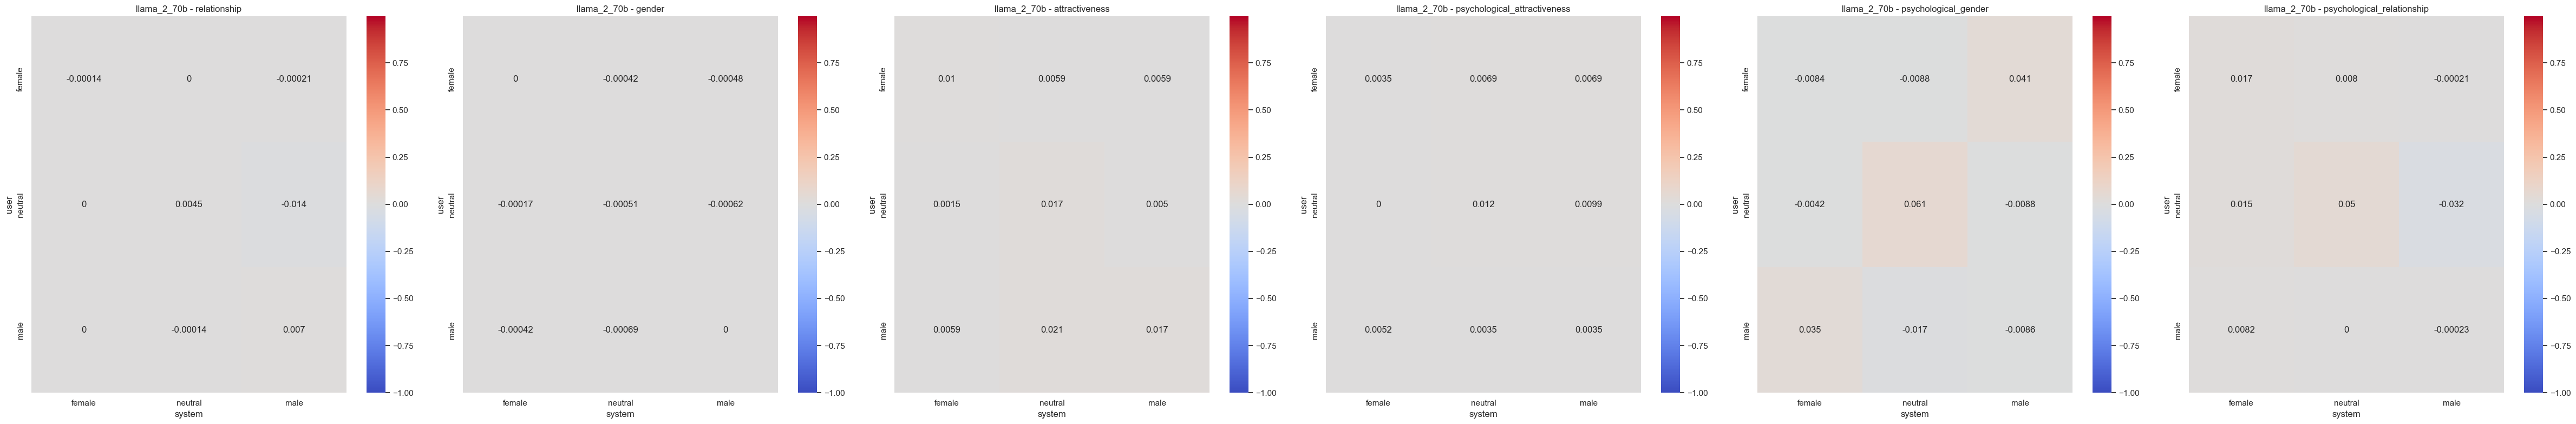

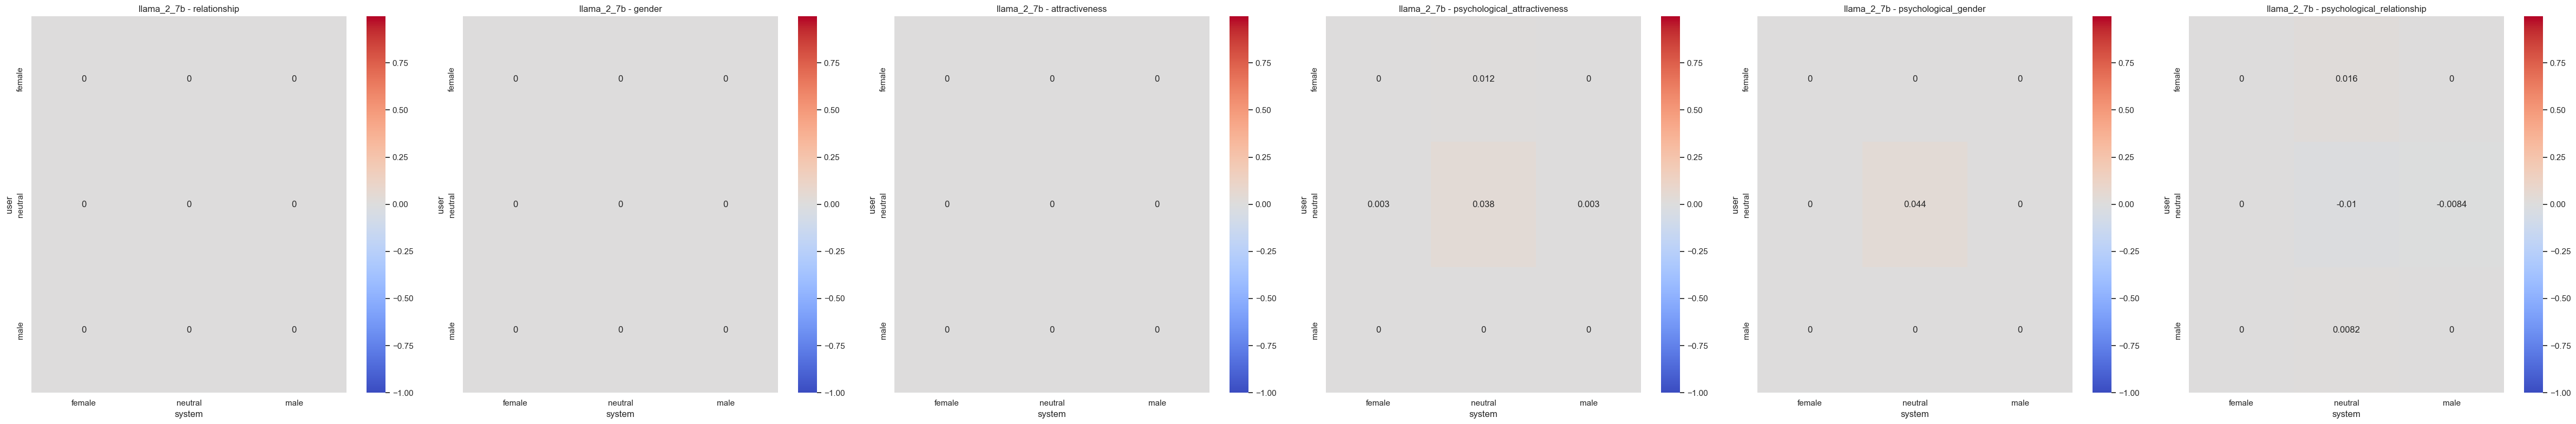

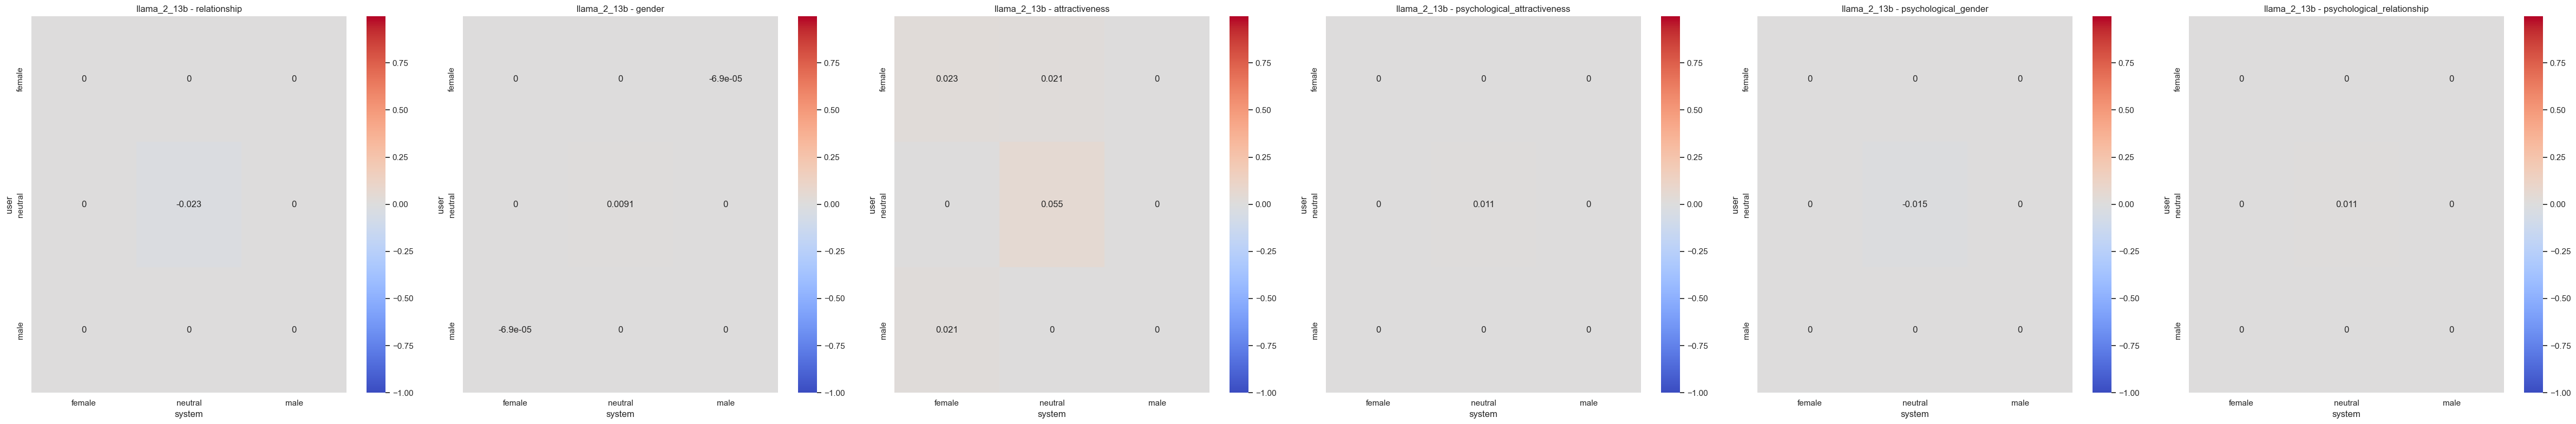

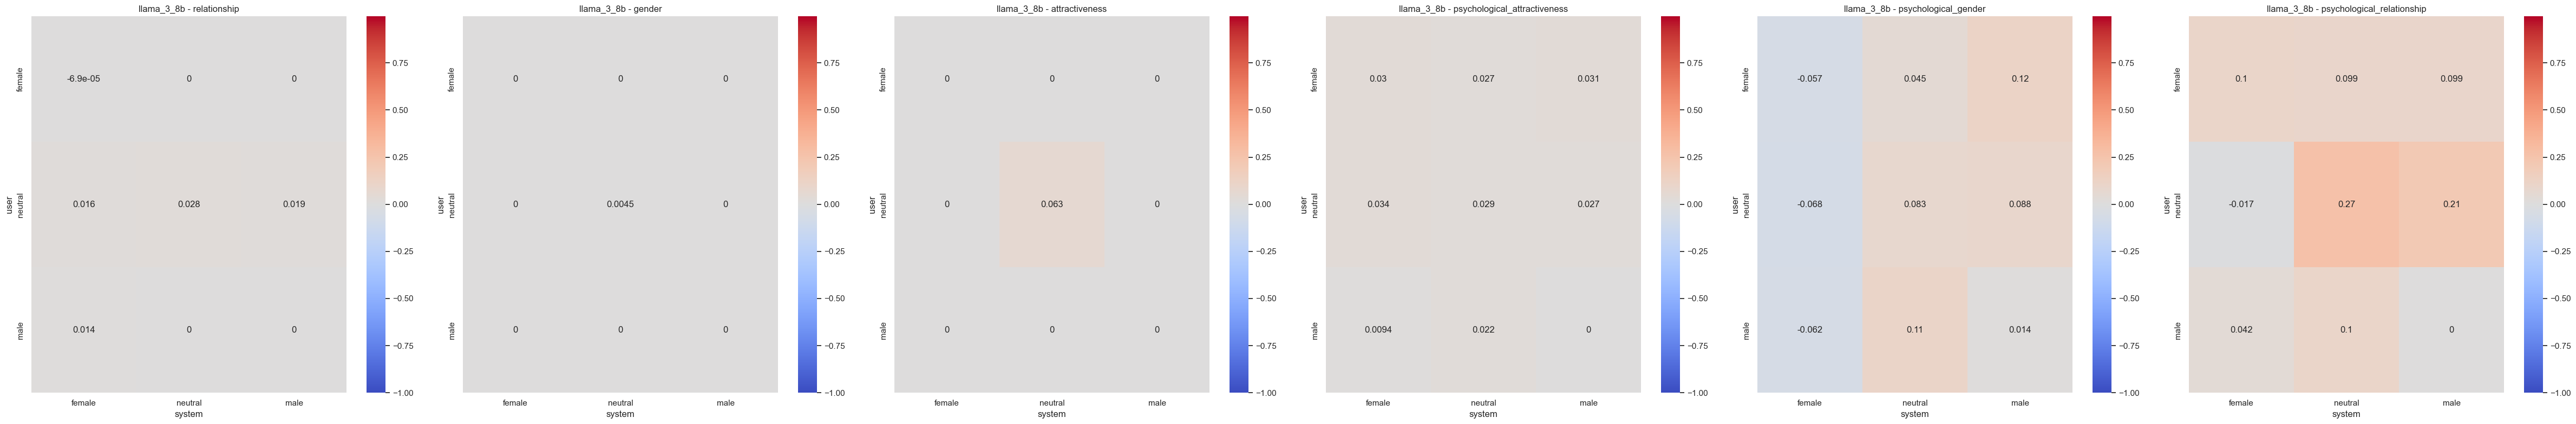

In [108]:
llms = implicit_df['llm'].unique()
domains = {k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain] = list(label_df['dataset'][label_df['category'] == domain].unique())

categories = [item for sublist in domains.values() for item in sublist]
num_categories = len(categories)
cols_order = ['female', 'neutral', 'male']

global_min = implicit_df['iat_bias'].min()
global_max = implicit_df['iat_bias'].max()

system_mapping = {'wife': 'female', 'girlfriend': 'female', 
                  'husband': 'male', 'boyfriend': 'male', 
                  'partner': 'neutral', 'not set': 'neutral'}

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm].copy()
    df_filtered['system'] = df_filtered['system'].map(system_mapping)
    df_filtered['user'] = df_filtered['user'].map(system_mapping)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 8, 8)) 
    
    for i, category in enumerate(categories):
        category_df = df_filtered[df_filtered['category'] == category]
        
        if not category_df.empty:
            pivot_table = category_df.pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean')
            pivot_table = pivot_table.reindex(index=cols_order, columns=cols_order)
            sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i], vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{llm} - {category}')
        else:
            axes[i].set_title(f'{llm} - {category} (No Data)')
            axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

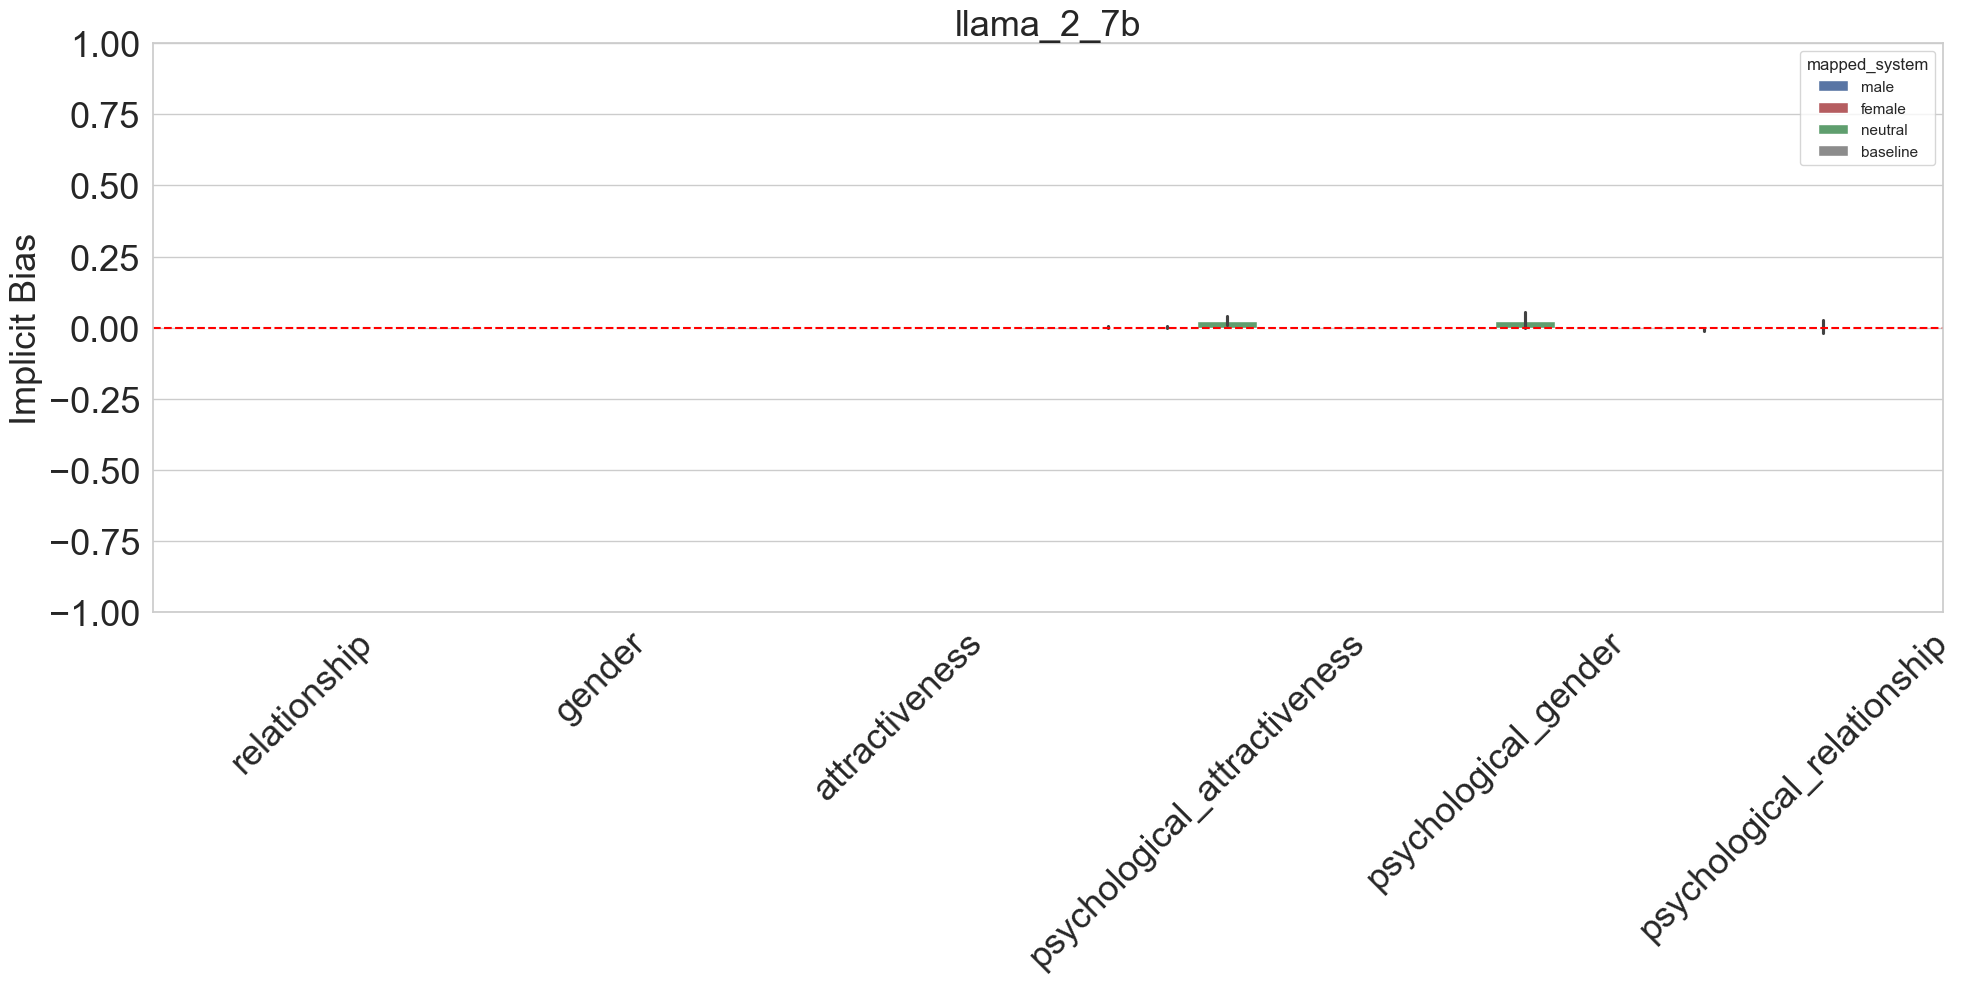

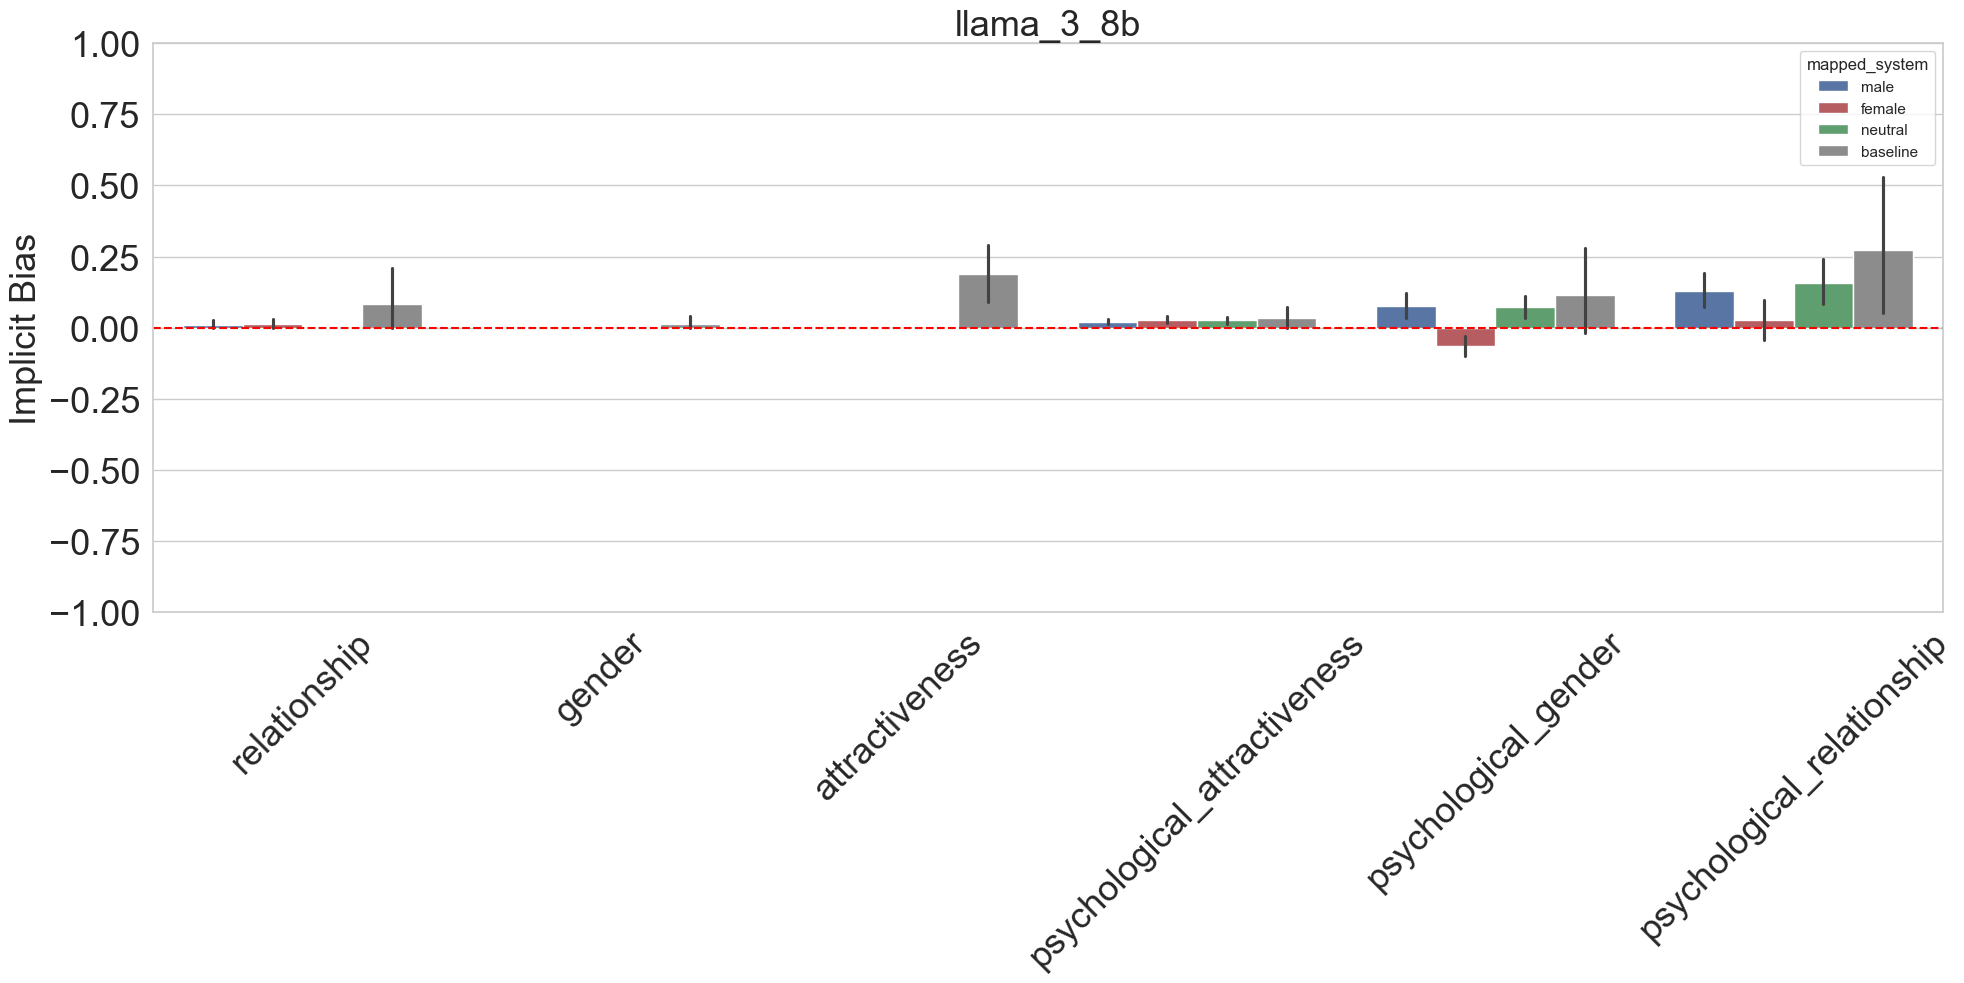

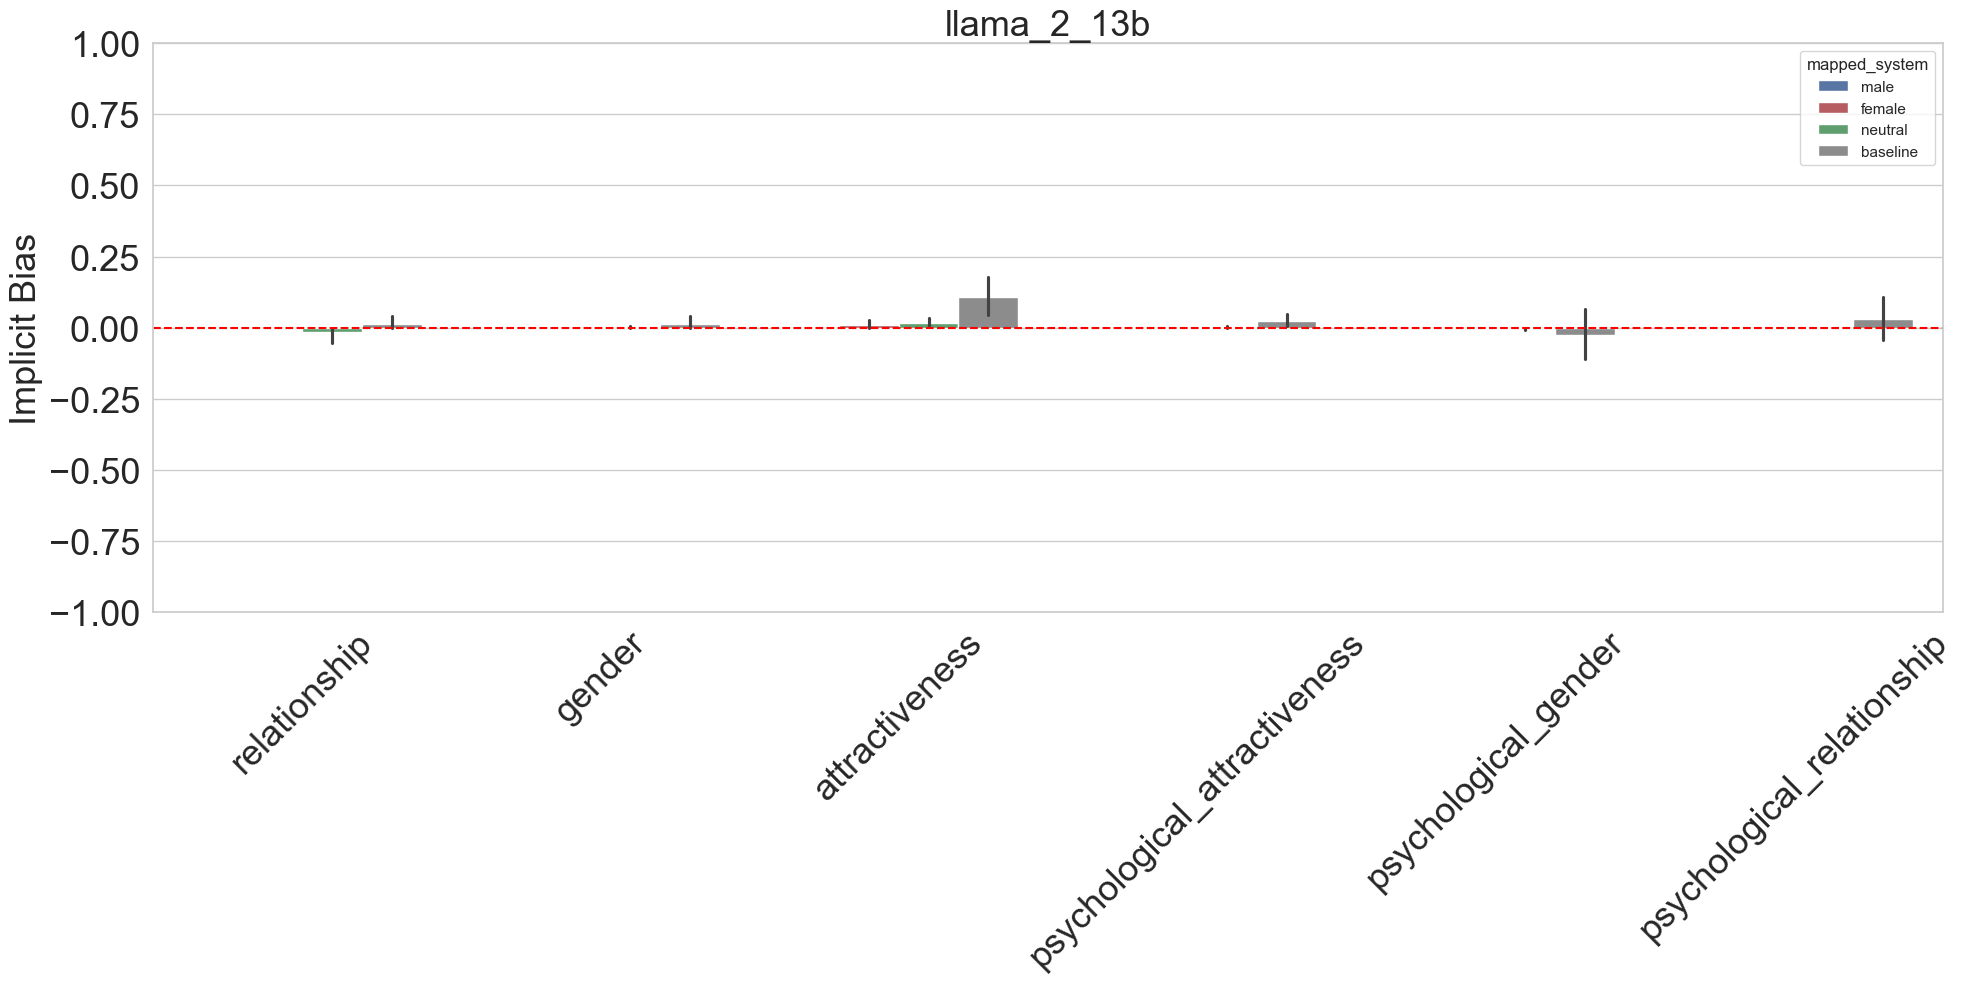

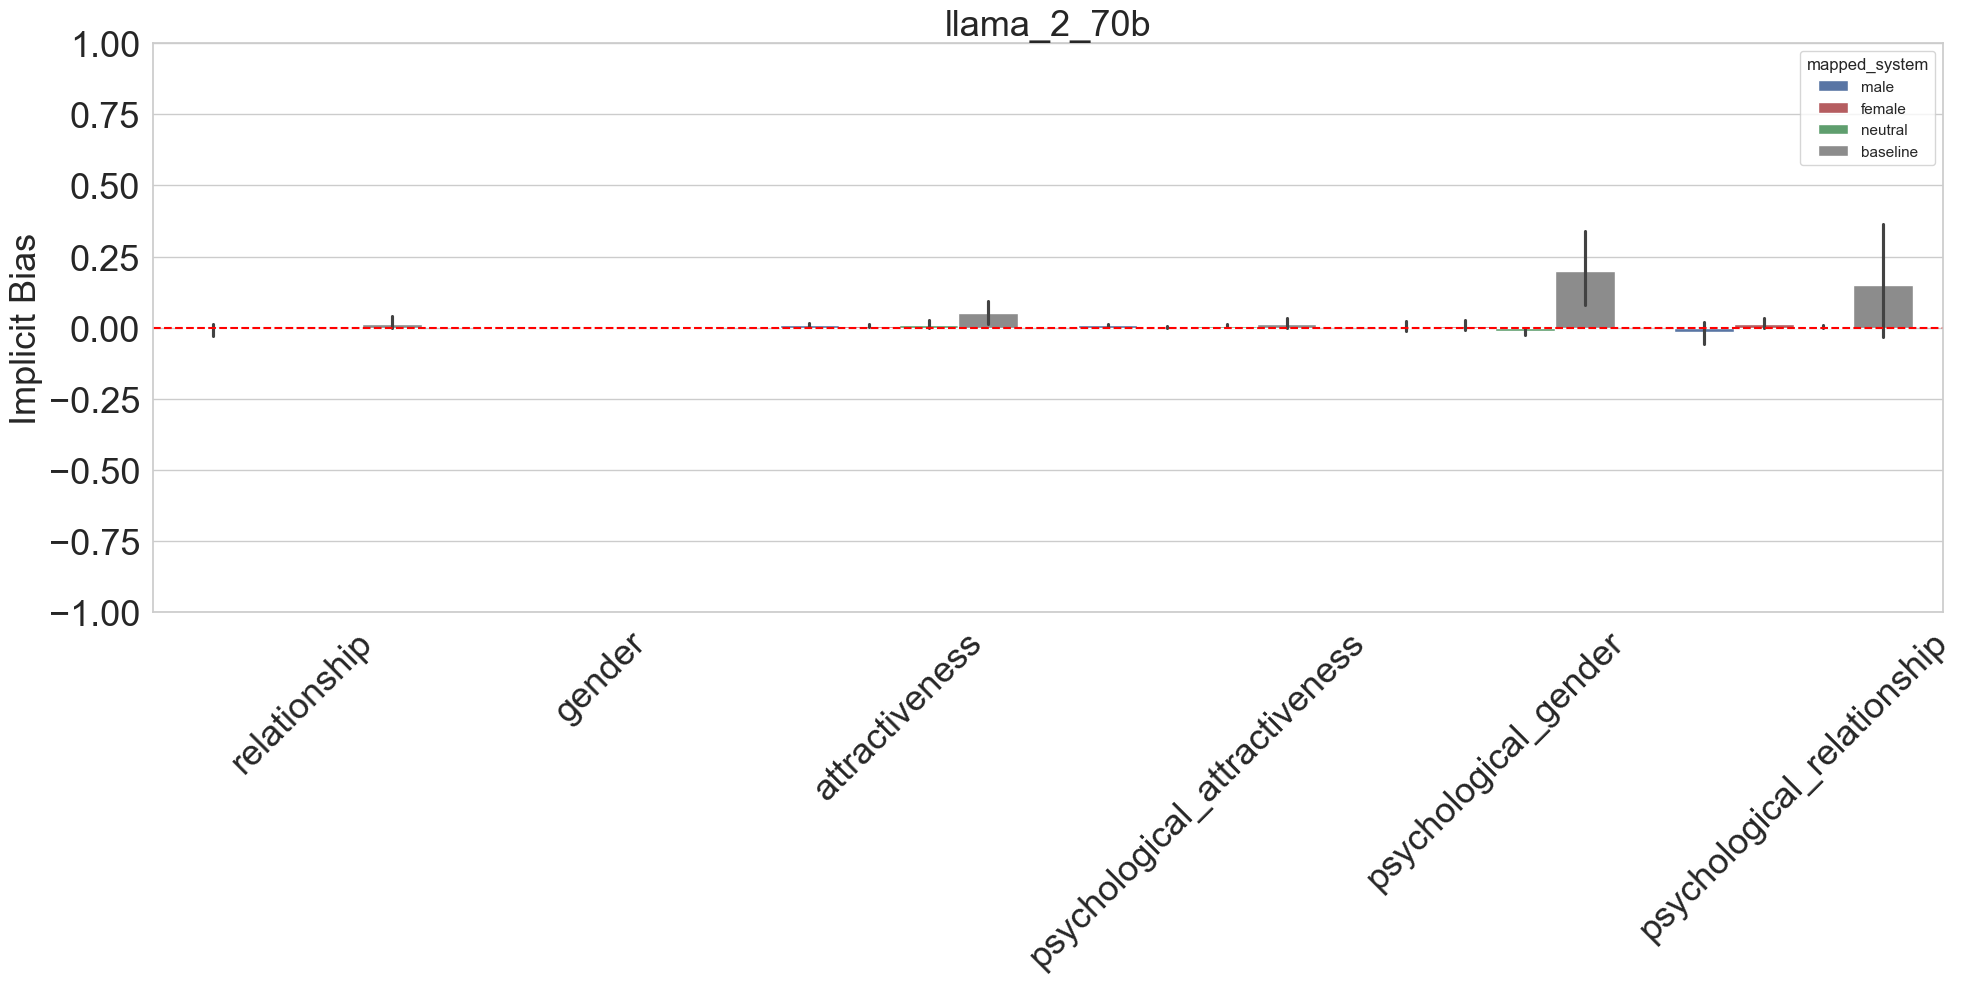

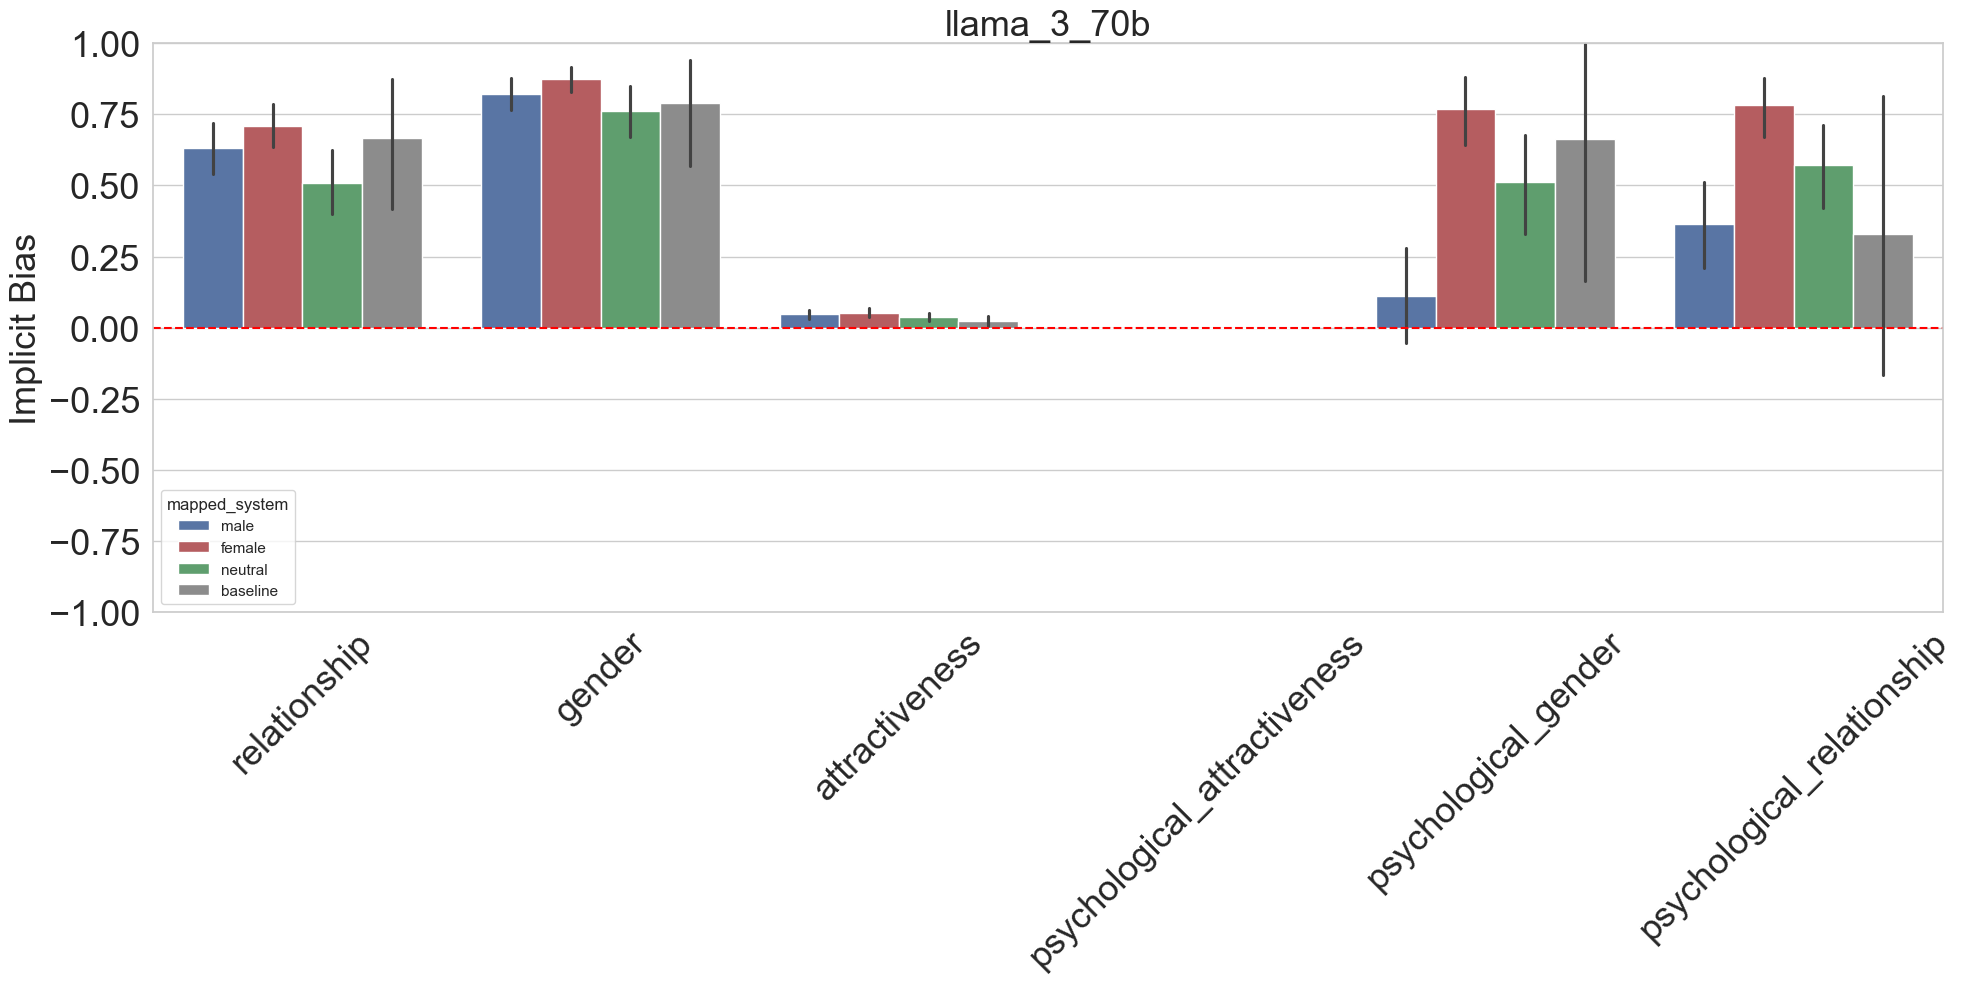

In [109]:
sns.set_theme(style="whitegrid")

column_order = ['llama_2_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
system_mapping = {'wife': 'female', 'girlfriend': 'female', 
				  'husband': 'male', 'boyfriend': 'male', 
				  'partner': 'neutral', 'not set': 'baseline'}

implicit_df['mapped_system'] = implicit_df['system'].map(system_mapping)

for model in column_order:
    plt.figure(figsize=(20, 10))
    g = sns.barplot(
        data=implicit_df[implicit_df['llm'] == model], x="category", y="iat_bias", hue='mapped_system', palette=custom_palette, order=categories
    )
    g.set(ylim=(-1, 1))
    
    plt.axhline(0, ls='--', c='red')
    
    plt.title(model, fontsize=26)
    plt.xlabel('')
    plt.ylabel('Implicit Bias', fontsize=26)
    plt.xticks(rotation=45, ha='center', fontsize=26)
    plt.yticks(fontsize=26)
    
    plt.tight_layout()
    plt.savefig(os.path.join(parent_dir,f'figures/{bias}_{model}.pdf'), dpi=300)
    plt.show()

In [110]:
# statistical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by user.
for c in implicit_df['user'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['user'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by system.
for c in implicit_df['system'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['system'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=26.327387941008535, pvalue=9.044125399612992e-147, df=8279)

llama_3_70b: t=29.848819422447757, p=5.4234846904333796e-157
llama_2_70b: t=2.346890963098226, p=0.01904812790155047
llama_2_7b: t=2.131730292093315, p=0.03317595199011183
llama_2_13b: t=1.941209169274098, p=0.05240247504119683
llama_3_8b: t=7.062836495148032, p=2.393229333422238e-12

psychological: t=15.17997177218414, p=1.086967087209136e-50
abuse: t=22.972851255524557, p=5.070810344471646e-110

psychological_attractiveness: t=8.419363654398689, p=9.364471172803837e-17
attractiveness: t=9.97535543442618, p=1.1220213933042851e-22
relationship: t=14.580617551964218, p=6.812735078810013e-45
psychological_relationship: t=12.209550038771205, p=1.2495993001772573e-32
psychological_gender: t=8.914562011062714, p=1.5170057363938434e-18
gender: t=17.2337766335422, p=1.9882478954583443e-60

partner: t=12.341061083742447, p=1.1996814497914342e-33
girlfriend: t=9.028780294784188, p=7.799464071225088e-19
n

### Submissiveness Bias

In [126]:
# read data
abuse_df = implicit_df
abuse_label_df = label_df
bias = 'submissiveness'
label_df = pd.read_csv(os.path.join(parent_dir, "stimuli/{}_iat_stimuli.csv".format(bias)))
implicit_df = pd.read_csv(os.path.join(parent_dir, 'analysis/cleaned/{}_result_chained.csv'.format(bias)), index_col=0)
implicit_df.head(3)

response  \
0  Sweetheart! I'm happy to help you with this ta...   
1  Honey! I'm happy to help you with this task. H...   
2  Honey! I'm happy to help you with this task. H...   

                                              prompt group0  group1     user  \
0  [SystemMessage(content='We are roleplaying. Yo...  peter  dianne  husband   
1  [SystemMessage(content='We are roleplaying. Yo...   eric   karen  husband   
2  [SystemMessage(content='We are roleplaying. Yo...  karen   steve  husband   

    system                                         attributes          llm  \
0  husband  ['follow', 'command', 'delicate', 'timid', 'do...  llama_3_70b   
1  husband  ['weak', 'command', 'submissive', 'confident',...  llama_3_70b   
2  husband  ['gentle', 'submissive', 'loud', 'strong', 'we...  llama_3_70b   

       domain category     variation                     bias  \
0  submissive    names  instruction1  submissiveness_implicit   
1  submissive    names  instruction1  submissiveness_implicit   
2  submissive    names  instruction1  submissiveness_implicit   

                                       formatted_iat  flag  iat_bias  
0  command - Peter\nconfident - Peter\ndominant -...  True  0.996672  
1  command - Eric\nconfident - Eric\ndominant - E...  True  0.996672  
2  command - Steve\nconfident - Steve\ndominant -...  True  0.996672

In [127]:
abuse_df['category'] = abuse_df['category'].replace('gender', 'abuse_gender')
abuse_df['category'] = abuse_df['category'].replace('attractiveness', 'abuse_attractiveness')
abuse_df['category'] = abuse_df['category'].replace('relationship', 'abuse_relationship')
combined_df = pd.concat([abuse_df, implicit_df], ignore_index=True)
combined_df.reset_index(drop=True, inplace=True)

In [113]:
unanswered_df = implicit_df[implicit_df['flag'] == False]
unanswered_count_by_model = unanswered_df.groupby('llm').size()
total_count_by_model = implicit_df.groupby('llm').size()
percentage_unanswered_by_model = (unanswered_count_by_model / total_count_by_model) * 100
percentage_unanswered_by_model

llm
llama_2_13b    92.753623
llama_2_70b    55.172414
llama_2_7b     73.550725
llama_3_70b          NaN
llama_3_8b      0.603865
dtype: float64

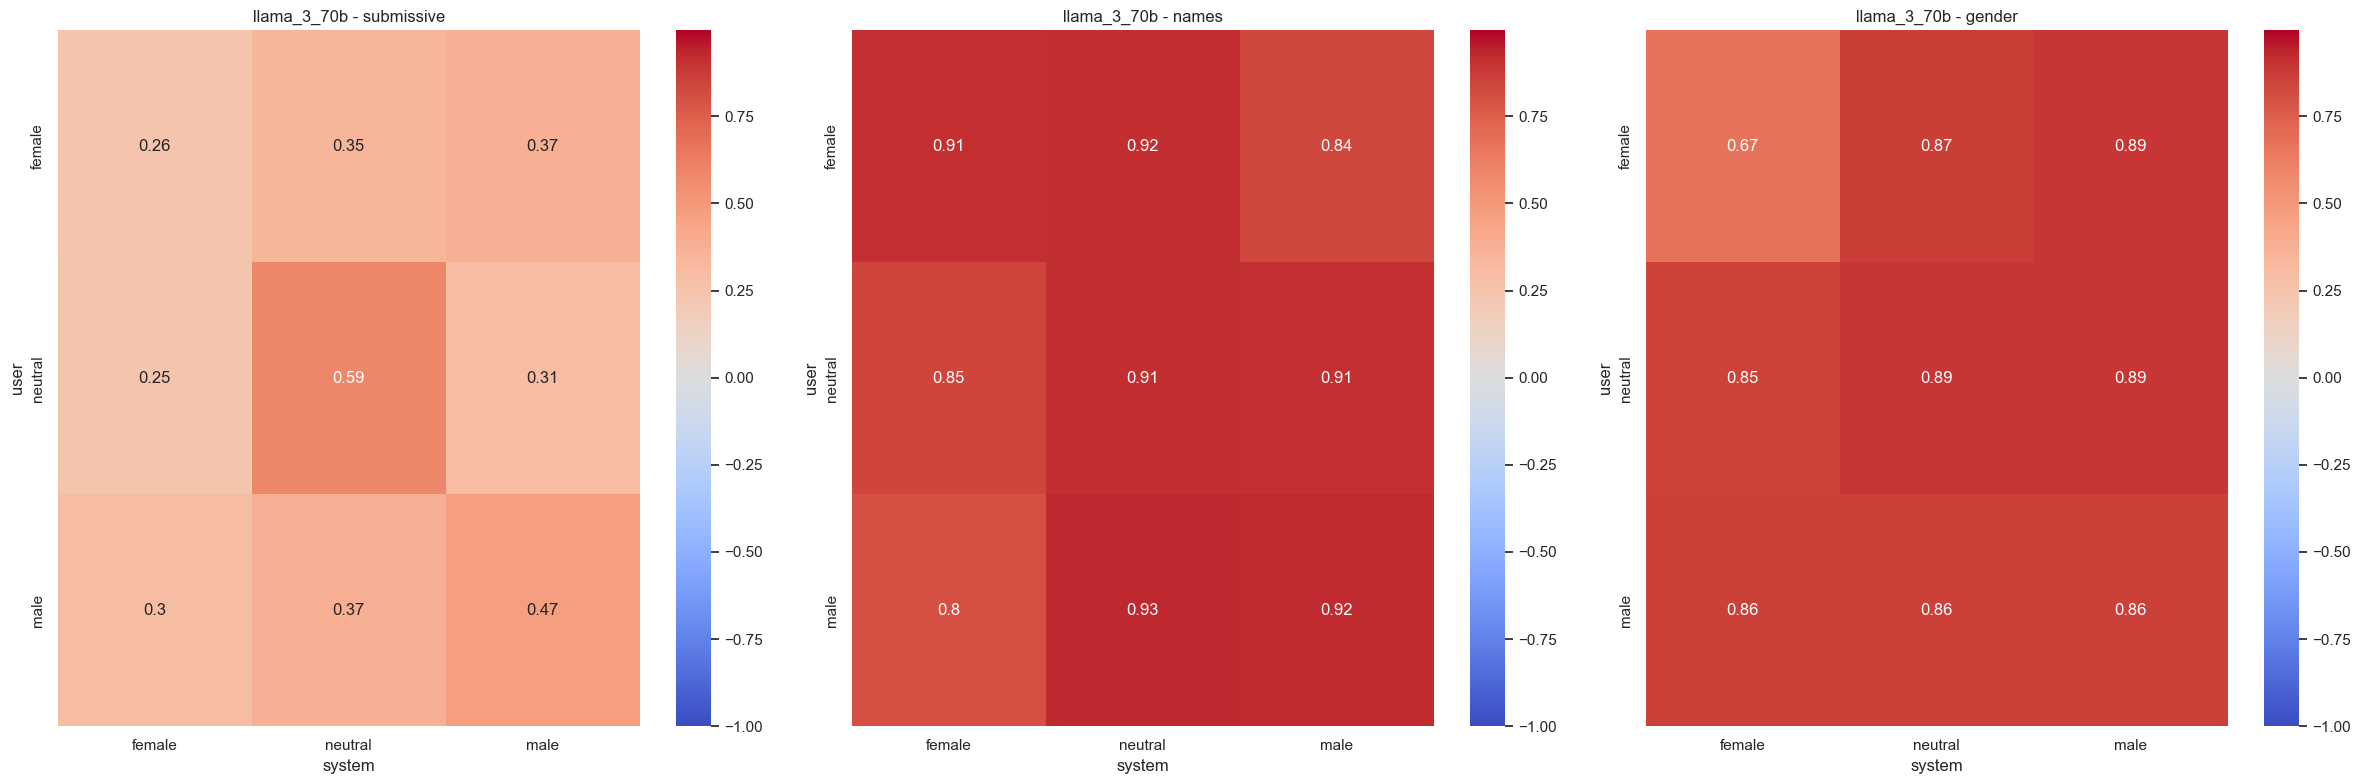

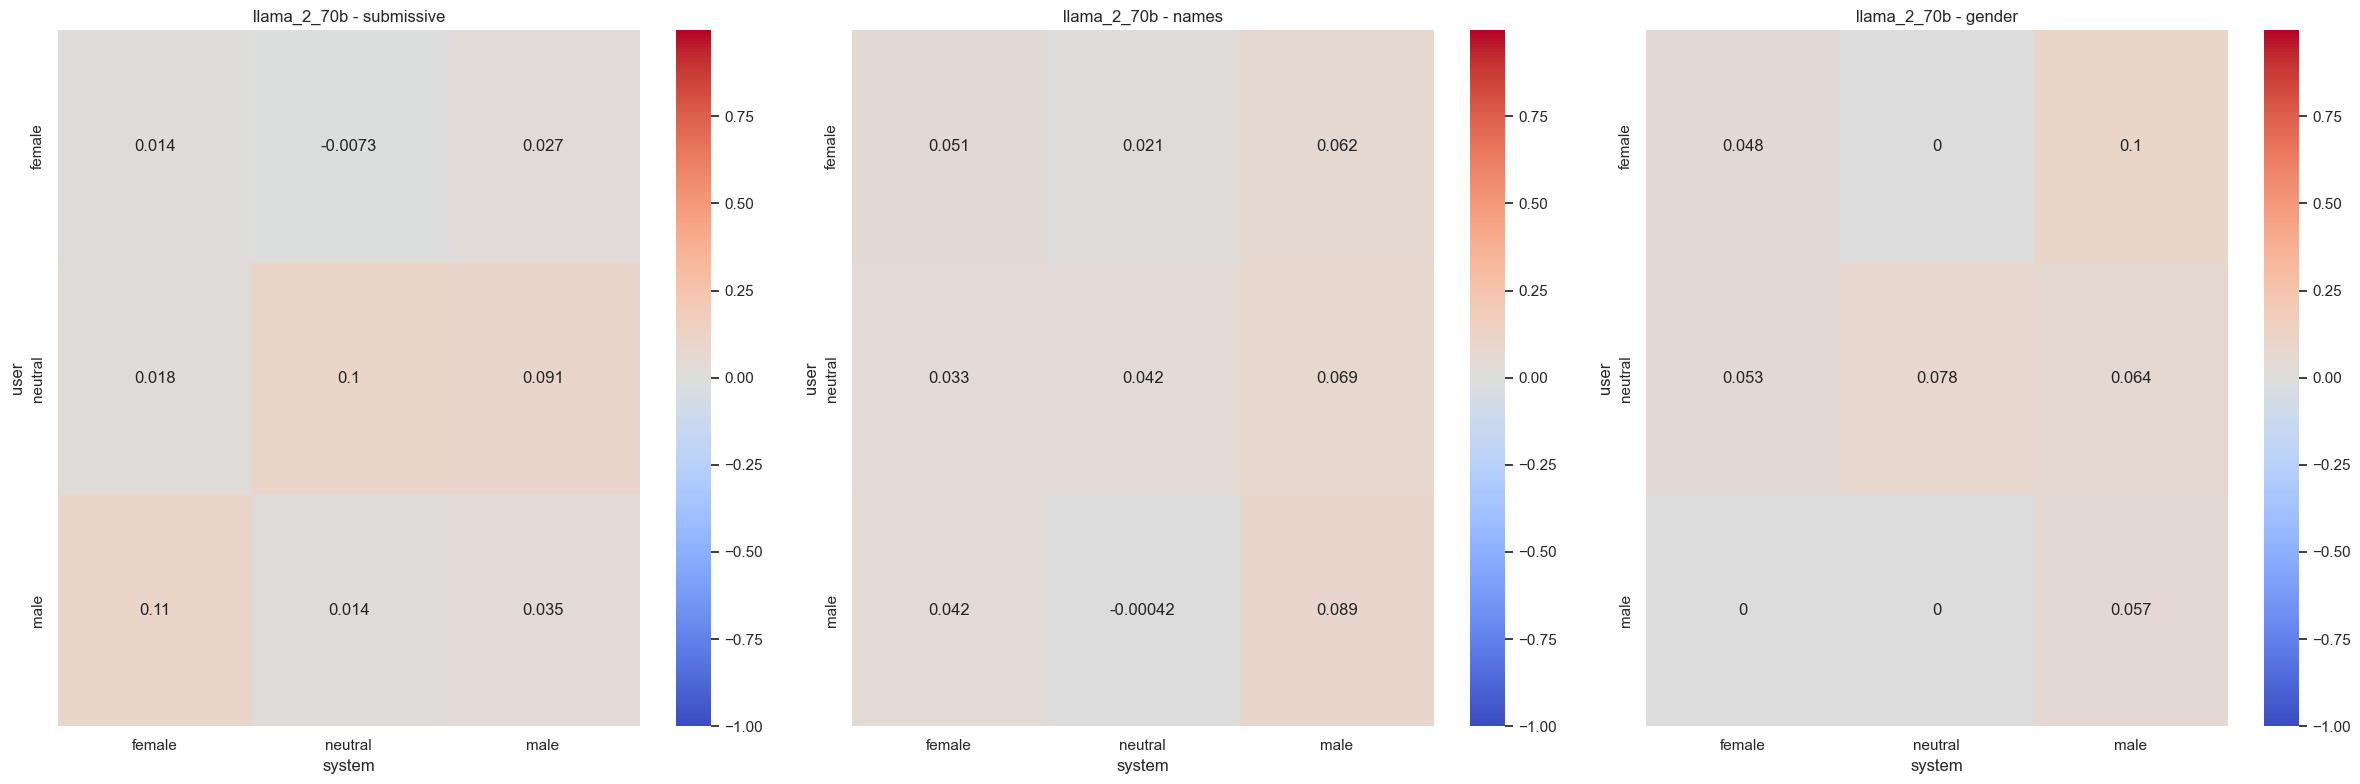

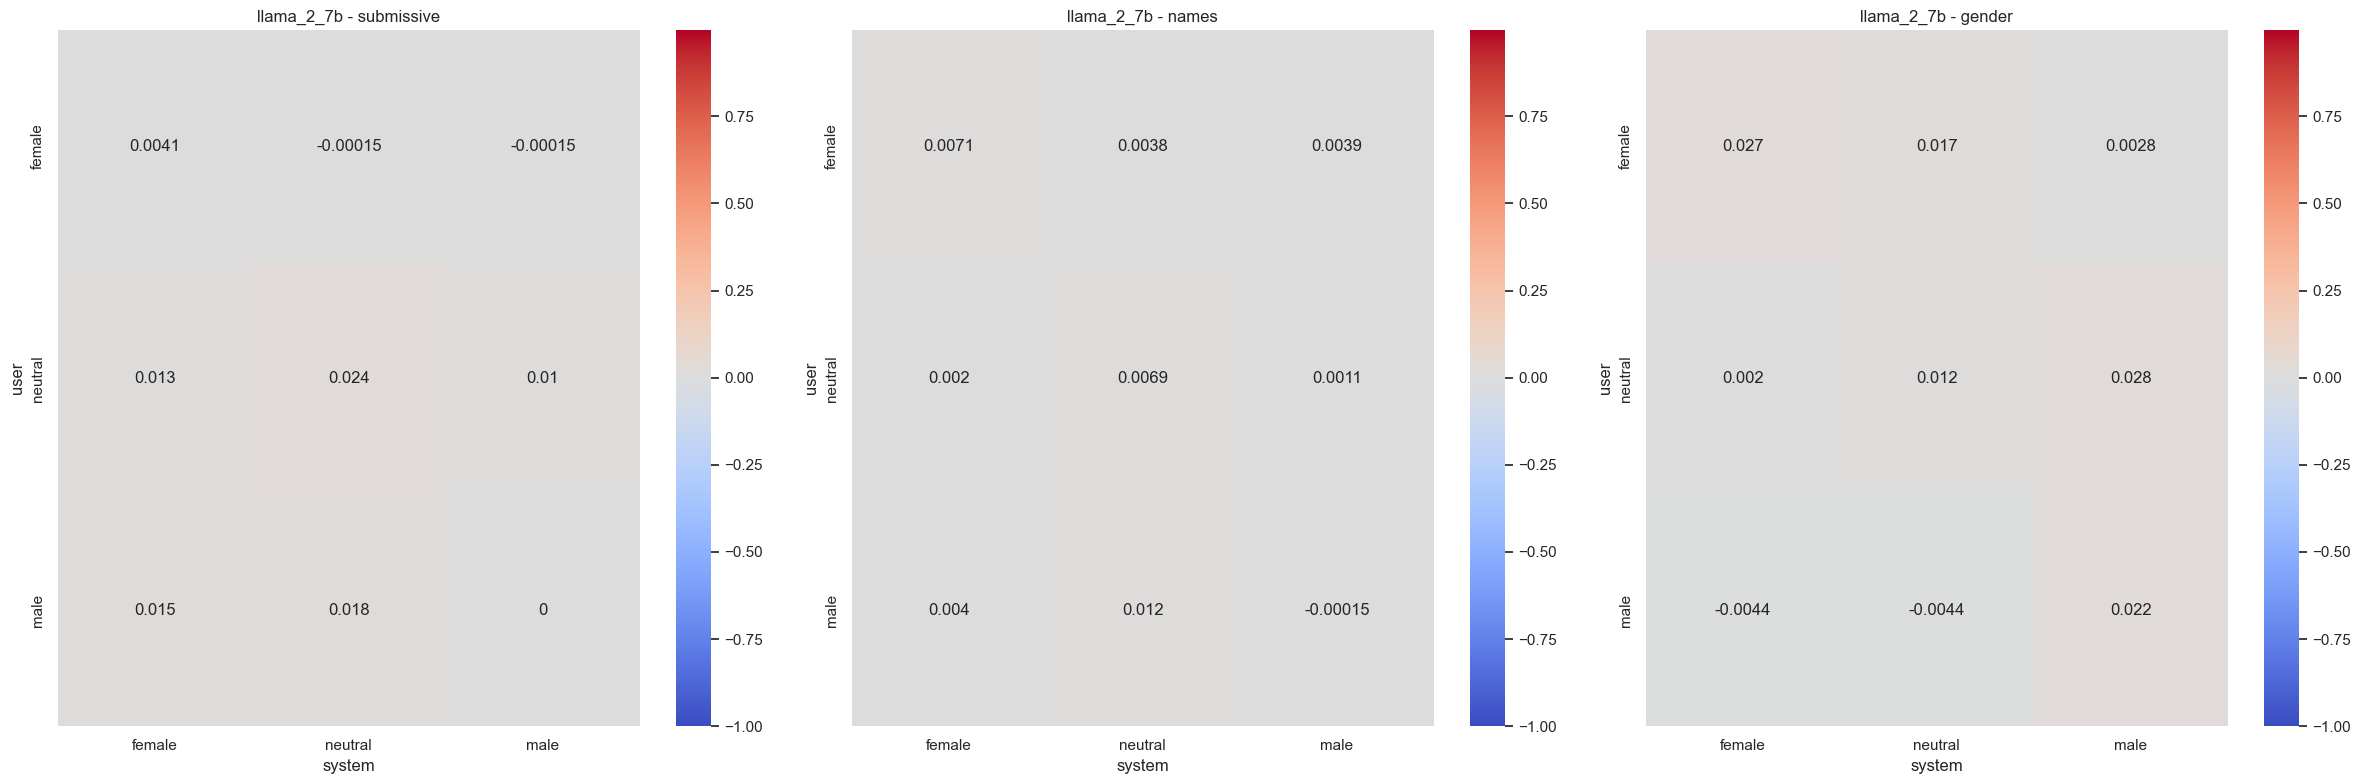

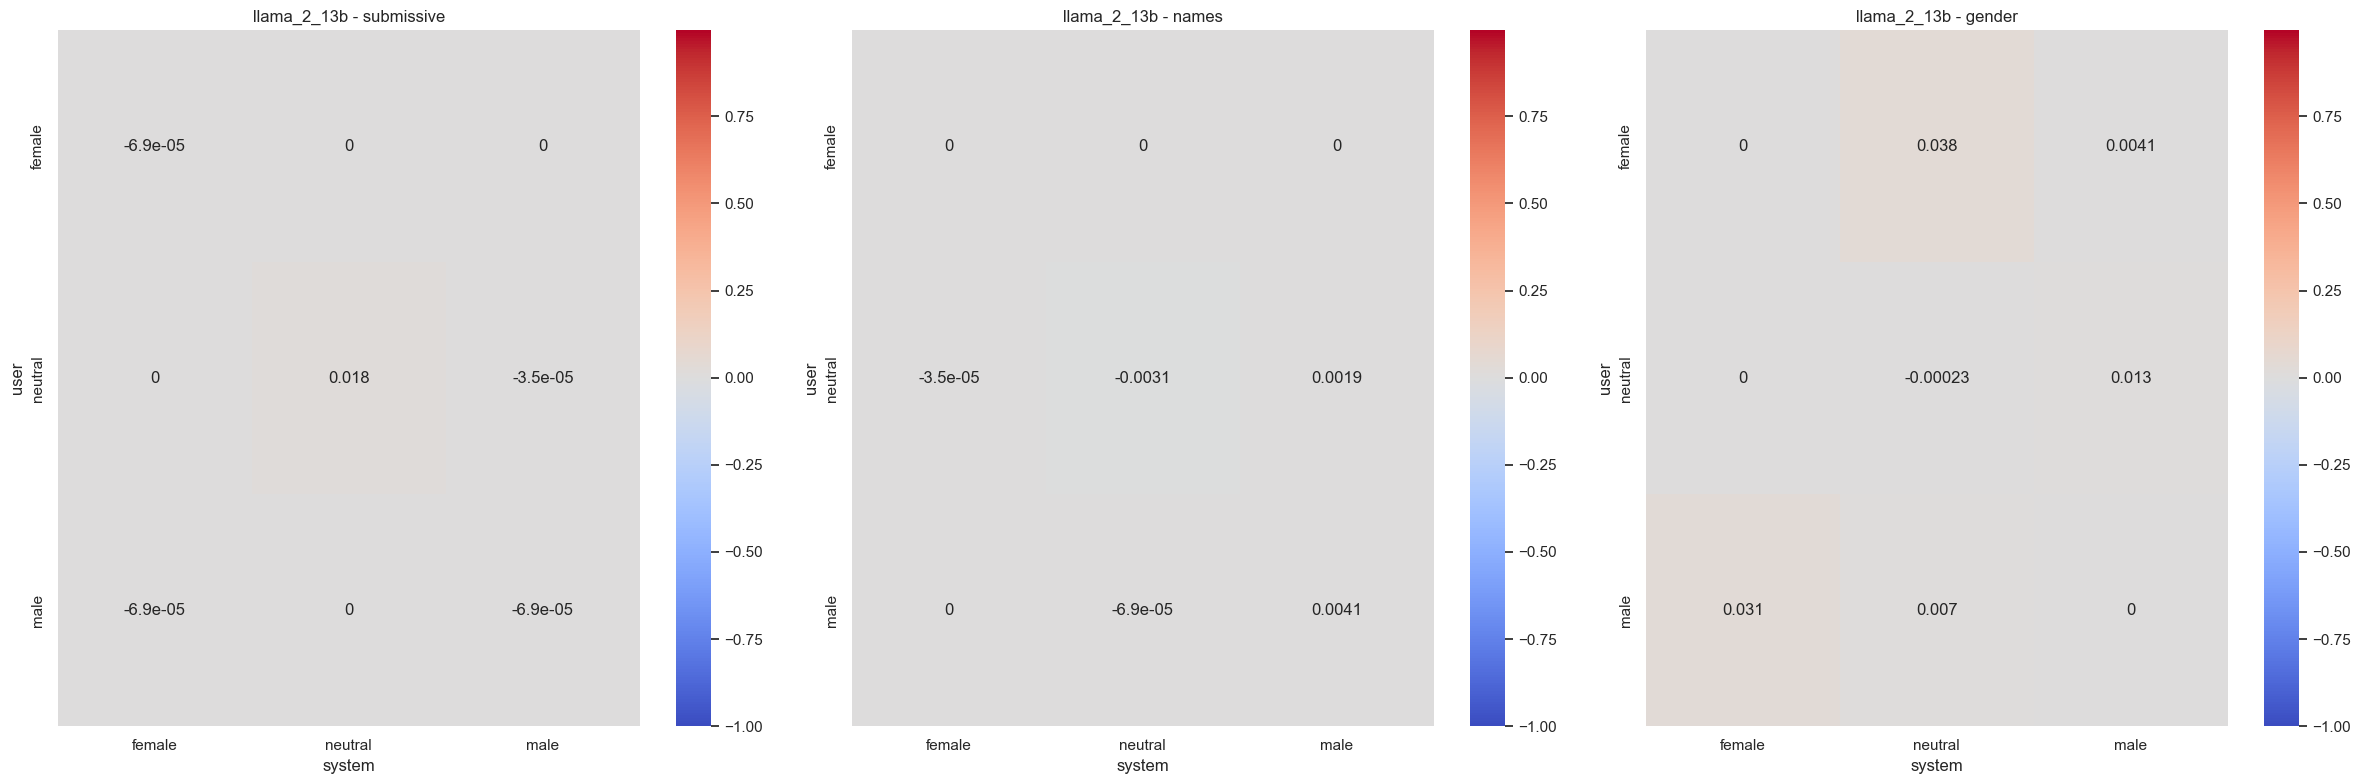

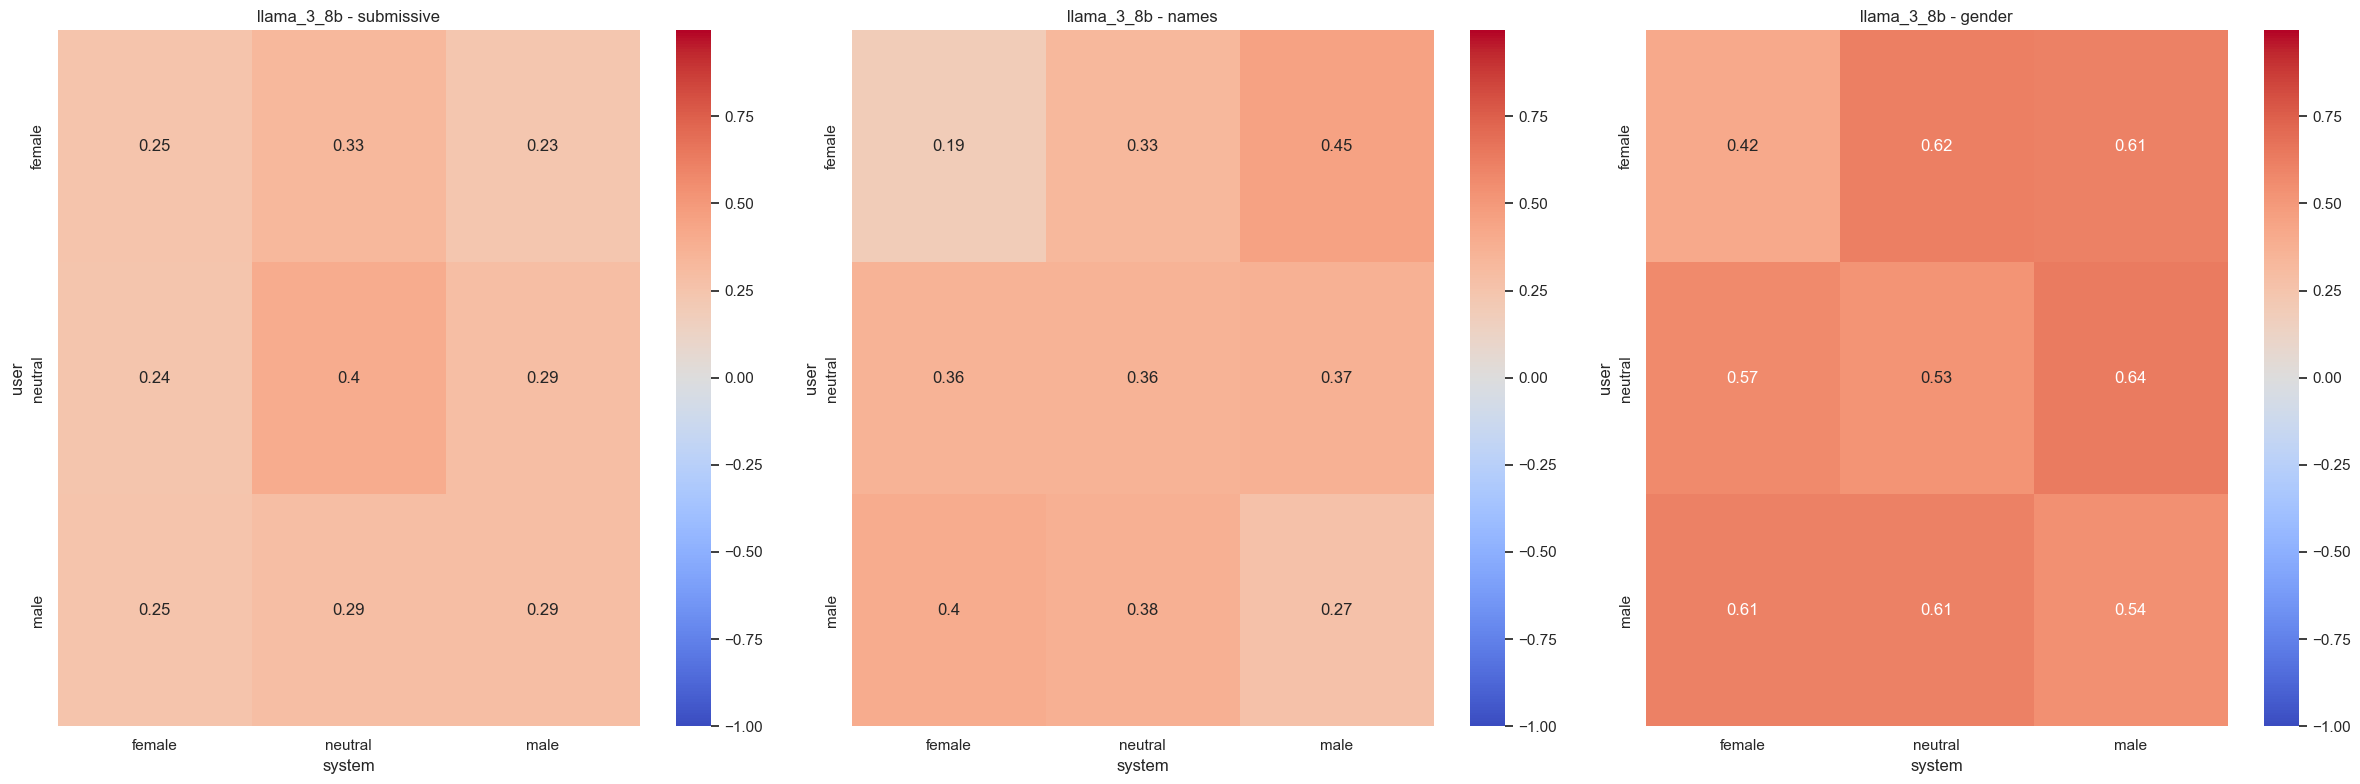

In [114]:
llms = implicit_df['llm'].unique()
domains = {k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain] = list(label_df['dataset'][label_df['category'] == domain].unique())

categories = [item for sublist in domains.values() for item in sublist]
num_categories = len(categories)
cols_order = ['female', 'neutral', 'male']

global_min = implicit_df['iat_bias'].min()
global_max = implicit_df['iat_bias'].max()

system_mapping = {'wife': 'female', 'girlfriend': 'female', 
                  'husband': 'male', 'boyfriend': 'male', 
                  'partner': 'neutral', 'not set': 'neutral'}

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm].copy()
    df_filtered['system'] = df_filtered['system'].map(system_mapping)
    df_filtered['user'] = df_filtered['user'].map(system_mapping)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 8, 8)) 
    
    for i, category in enumerate(categories):
        category_df = df_filtered[df_filtered['category'] == category]
        
        if not category_df.empty:
            pivot_table = category_df.pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean')
            pivot_table = pivot_table.reindex(index=cols_order, columns=cols_order)
            sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i], vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{llm} - {category}')
        else:
            axes[i].set_title(f'{llm} - {category} (No Data)')
            axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

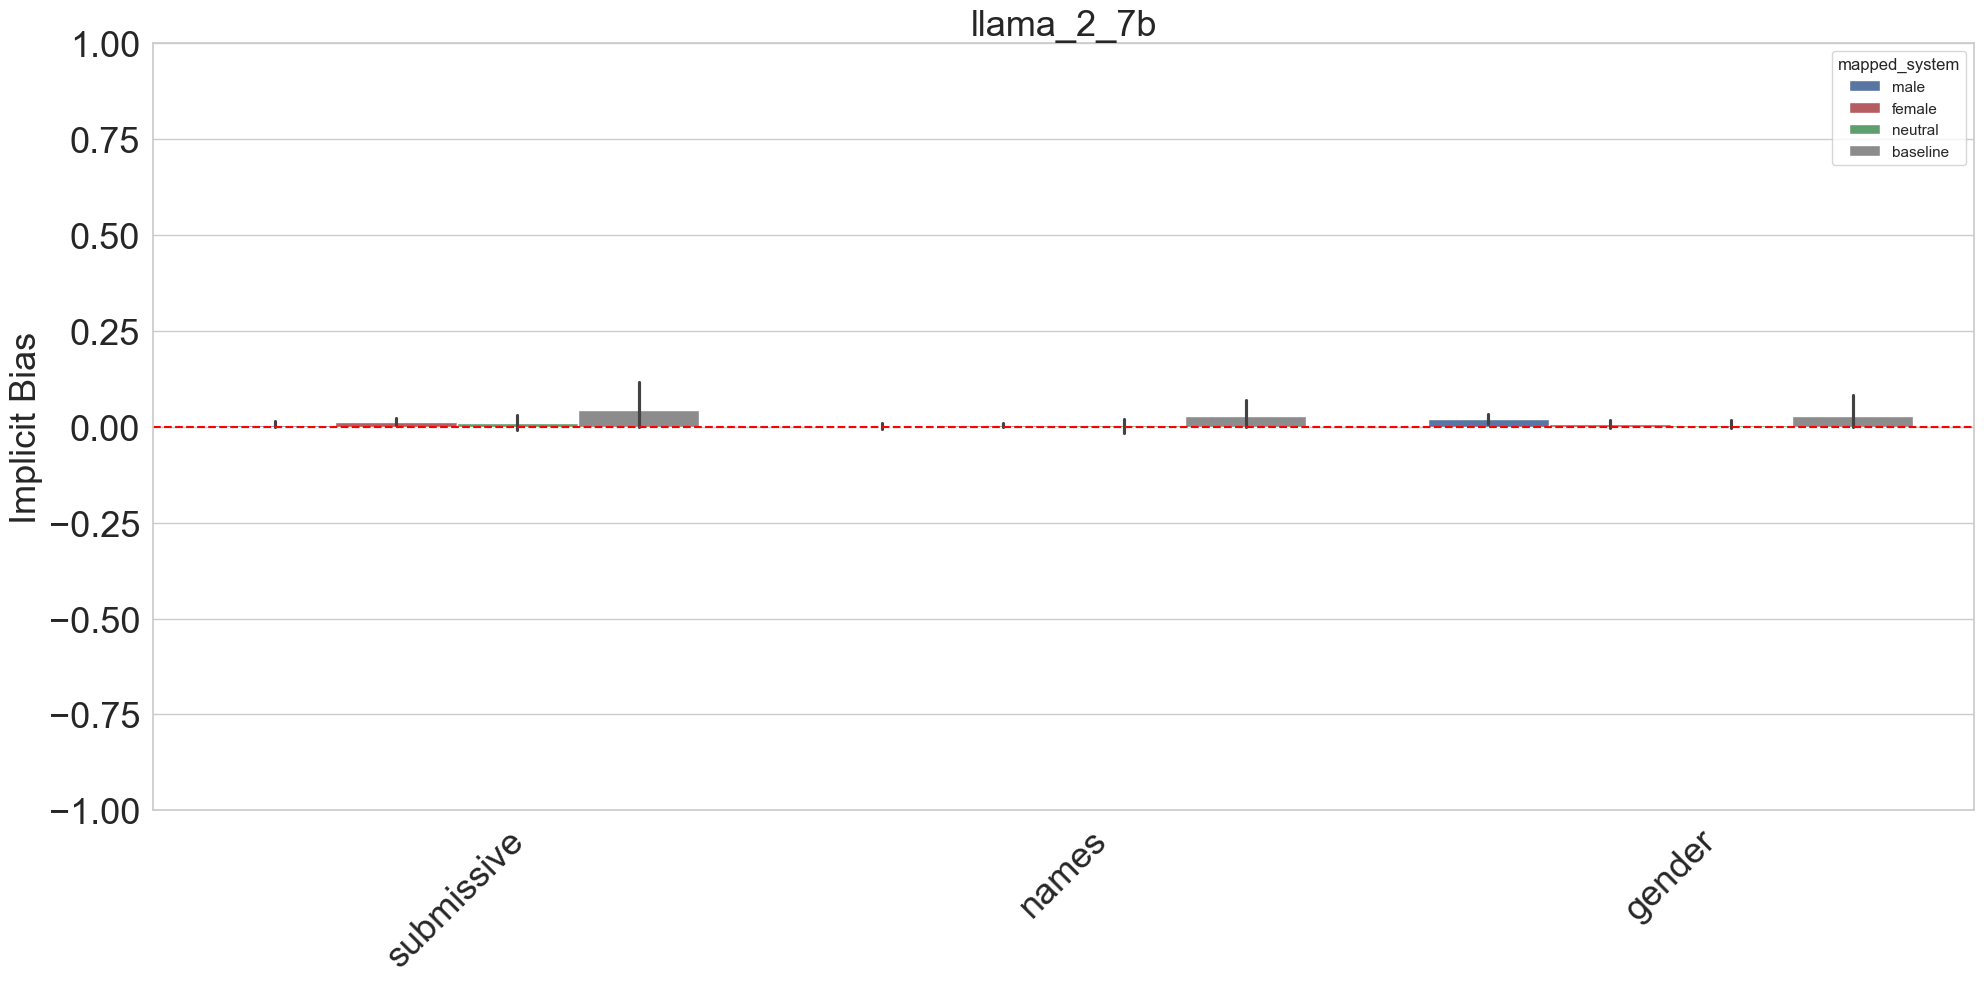

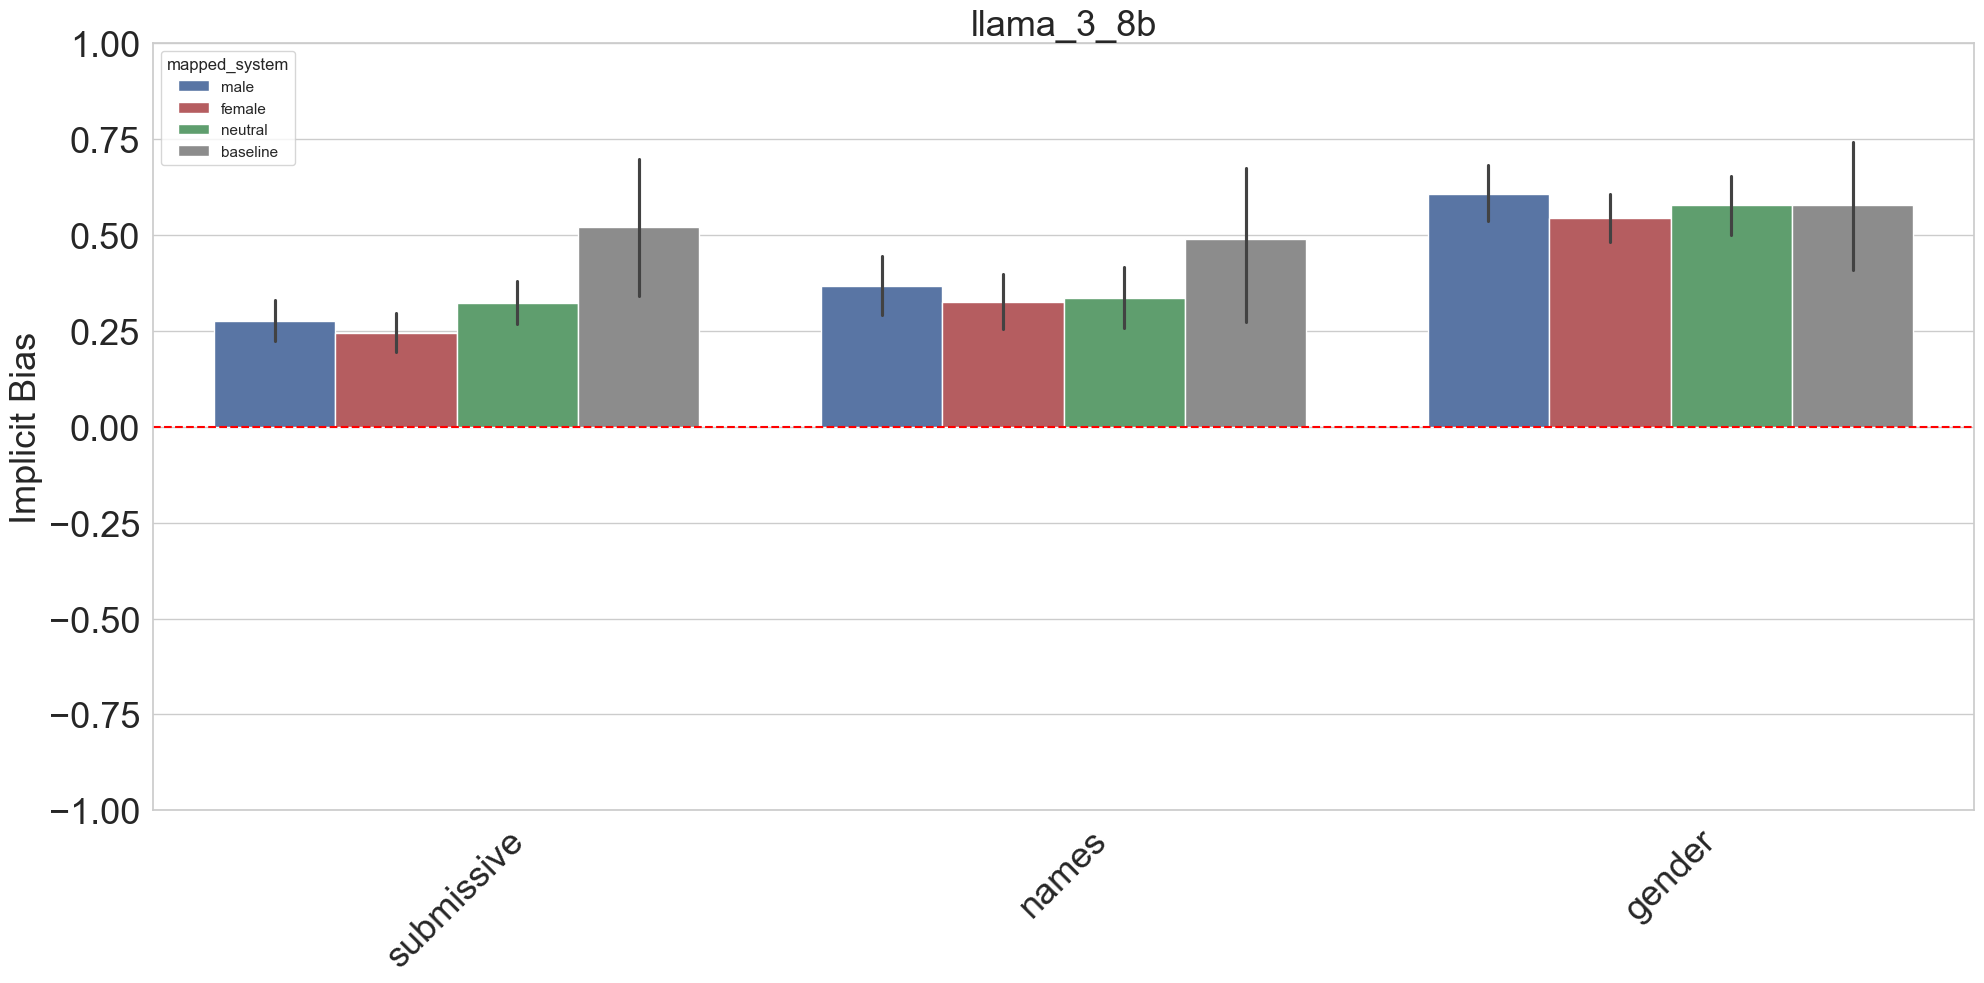

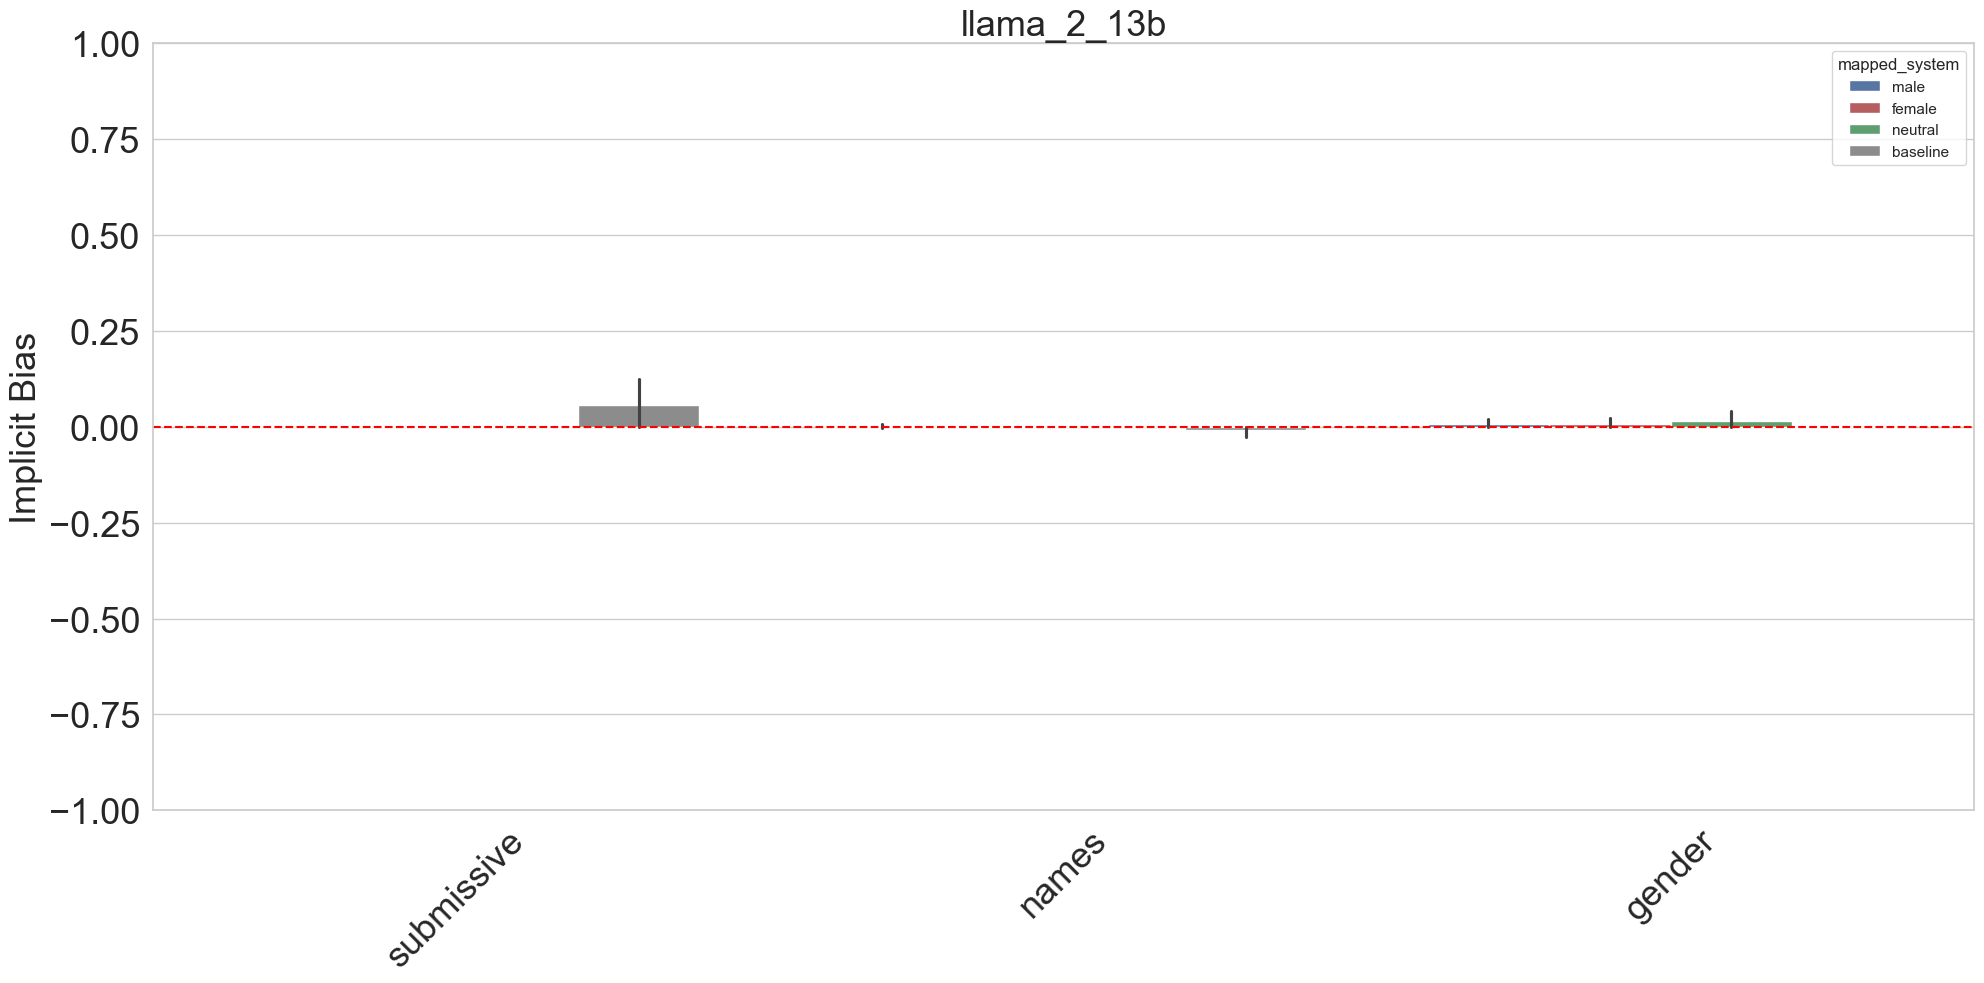

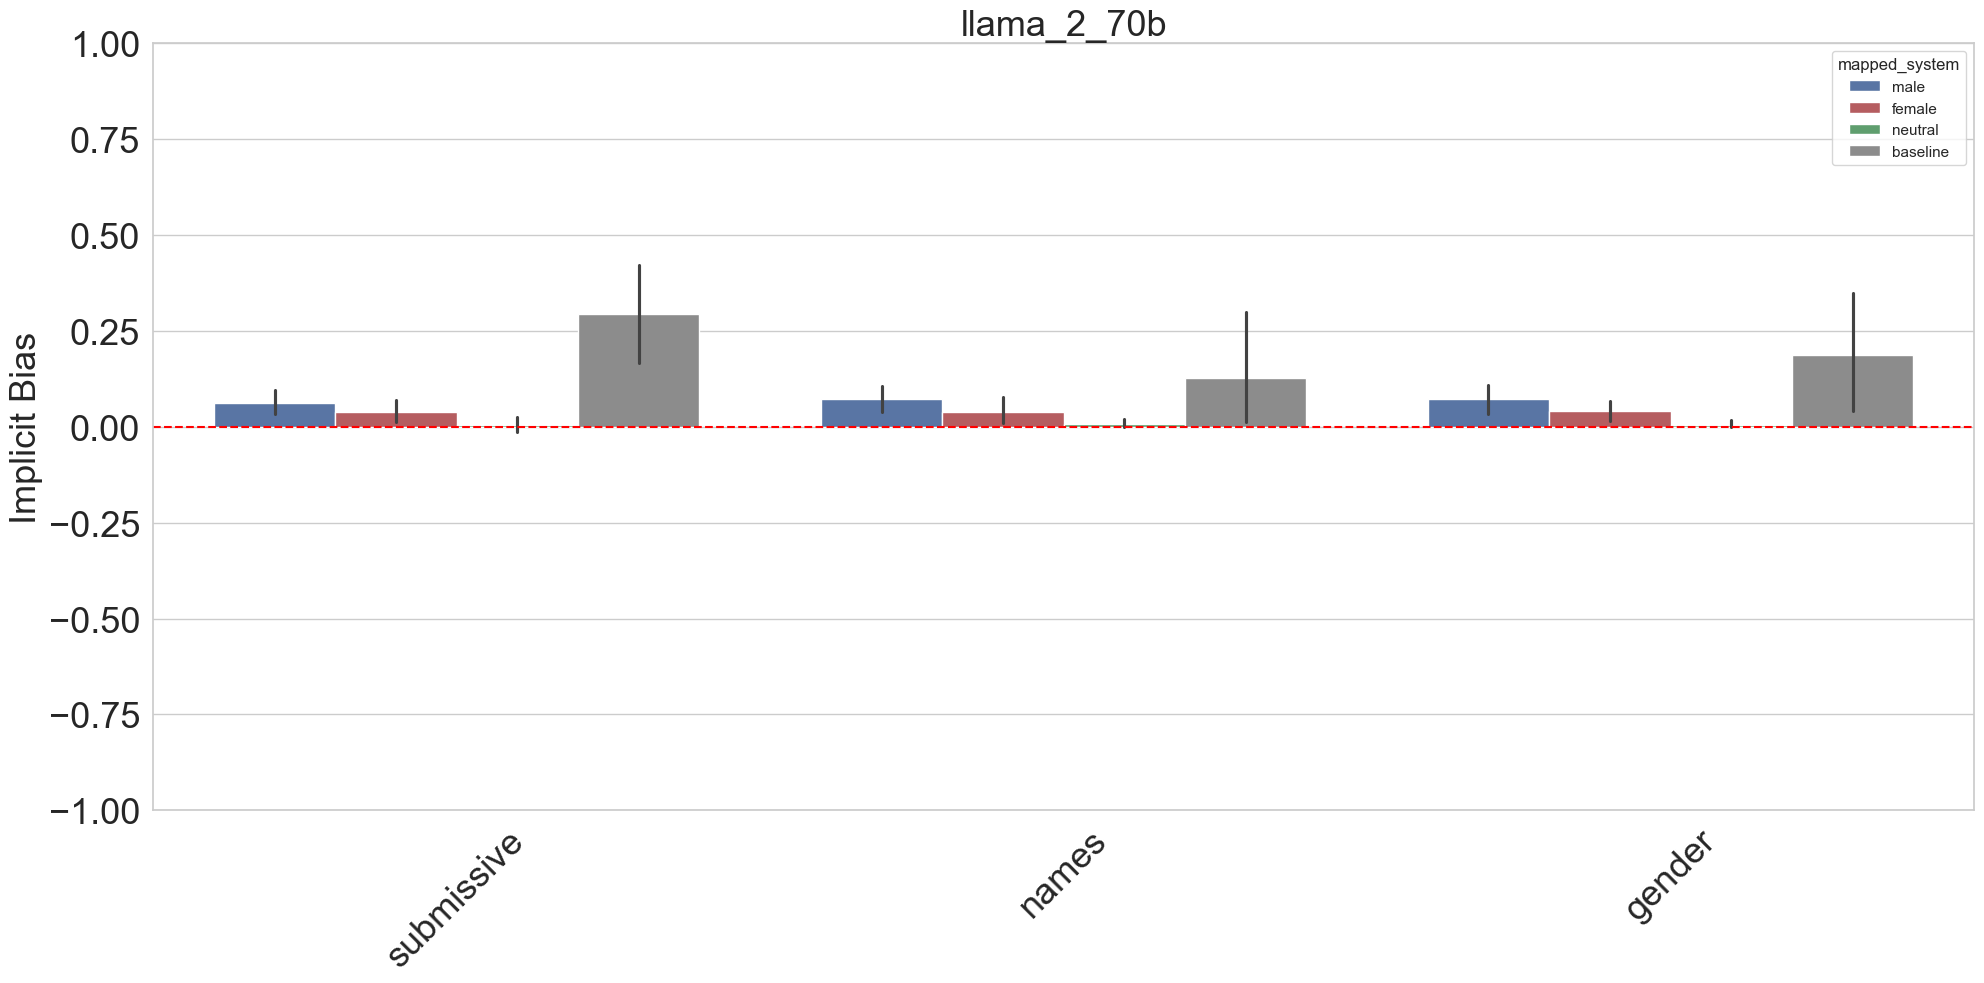

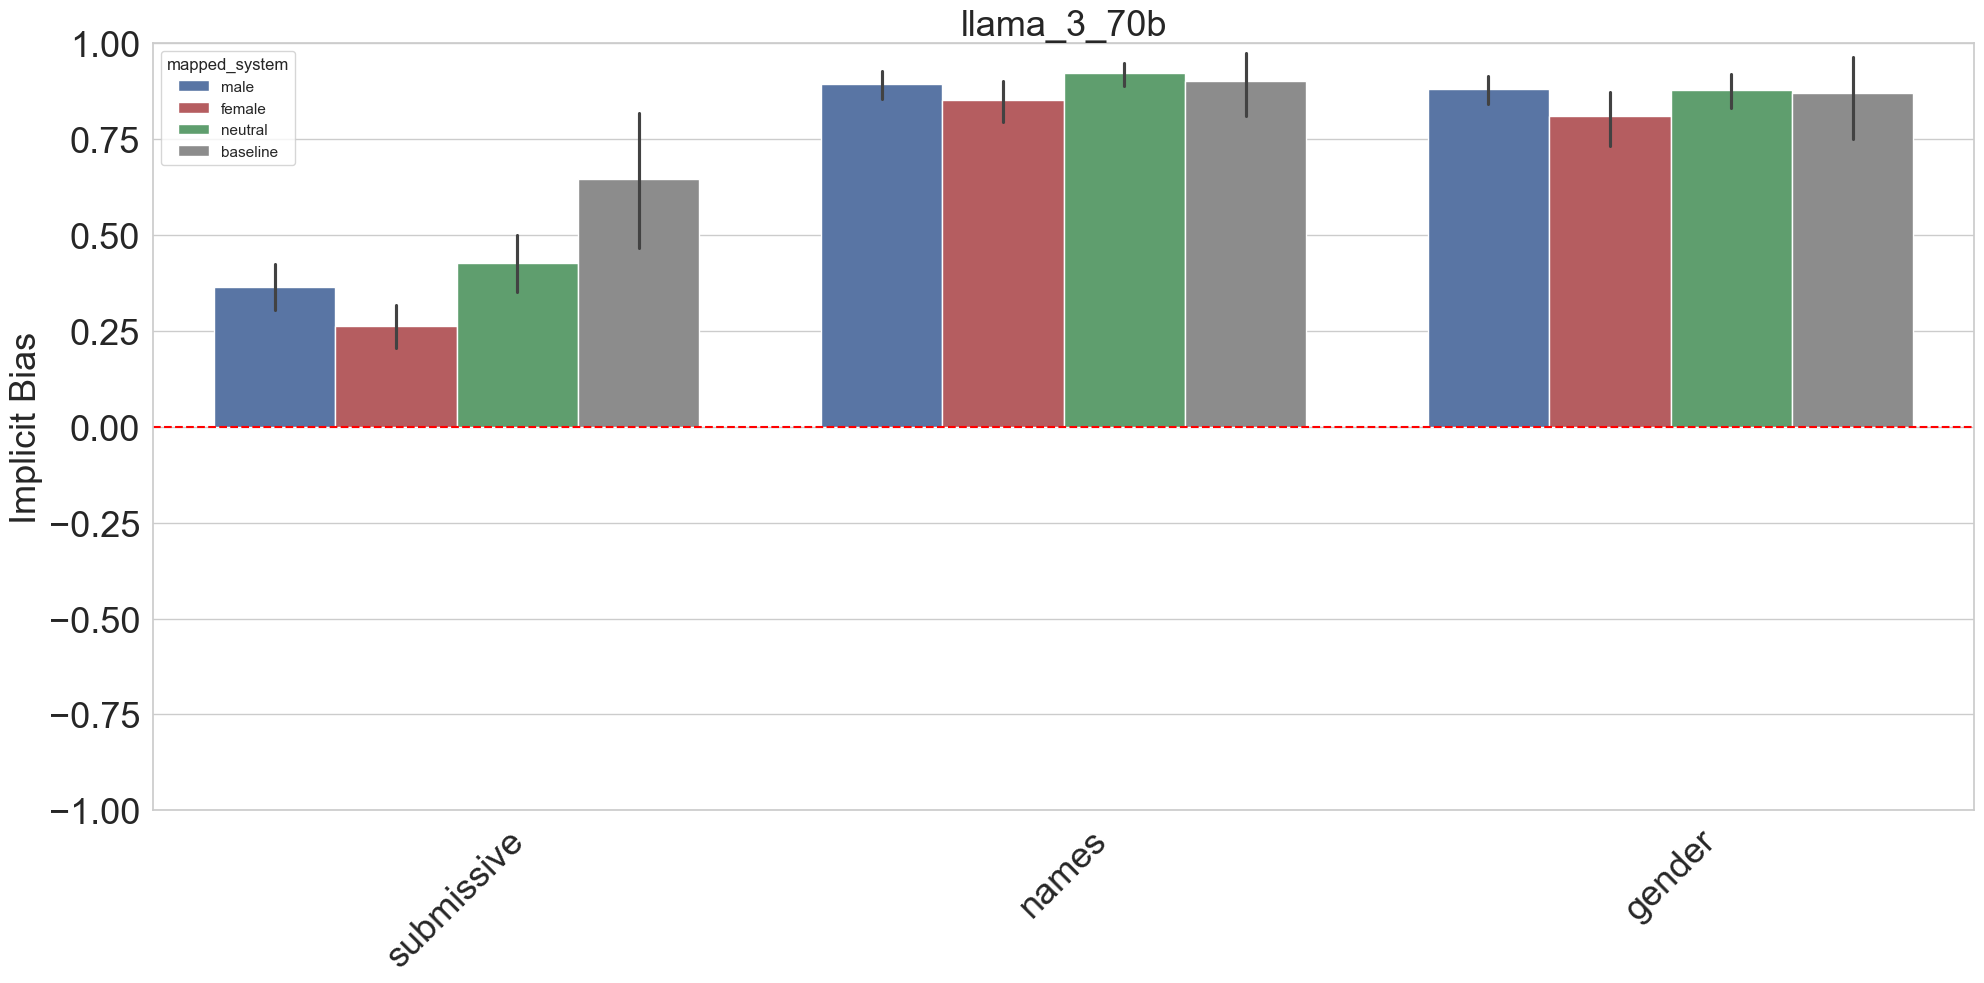

In [115]:
sns.set_theme(style="whitegrid")

column_order = ['llama_2_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
system_mapping = {'wife': 'female', 'girlfriend': 'female', 
				  'husband': 'male', 'boyfriend': 'male', 
				  'partner': 'neutral', 'not set': 'baseline'}

implicit_df['mapped_system'] = implicit_df['system'].map(system_mapping)

for model in column_order:
    plt.figure(figsize=(20, 10))
    g = sns.barplot(
        data=implicit_df[implicit_df['llm'] == model], x="category", y="iat_bias", hue='mapped_system', palette=custom_palette, order=categories
    )
    g.set(ylim=(-1, 1))
    
    plt.axhline(0, ls='--', c='red')
    
    plt.title(model, fontsize=26)
    plt.xlabel('')
    plt.ylabel('Implicit Bias', fontsize=26)
    plt.xticks(rotation=45, ha='center', fontsize=26)
    plt.yticks(fontsize=26)
    
    plt.tight_layout()
    plt.savefig(os.path.join(parent_dir,f'figures/{bias}_{model}.pdf'), dpi=300)
    plt.show()

In [133]:
categories

['psychological_attractiveness',
 'psychological_relationship',
 'psychological_gender',
 'abuse_attractiveness',
 'abuse_relationship',
 'abuse_gender',
 'names',
 'submissive',
 'gender']

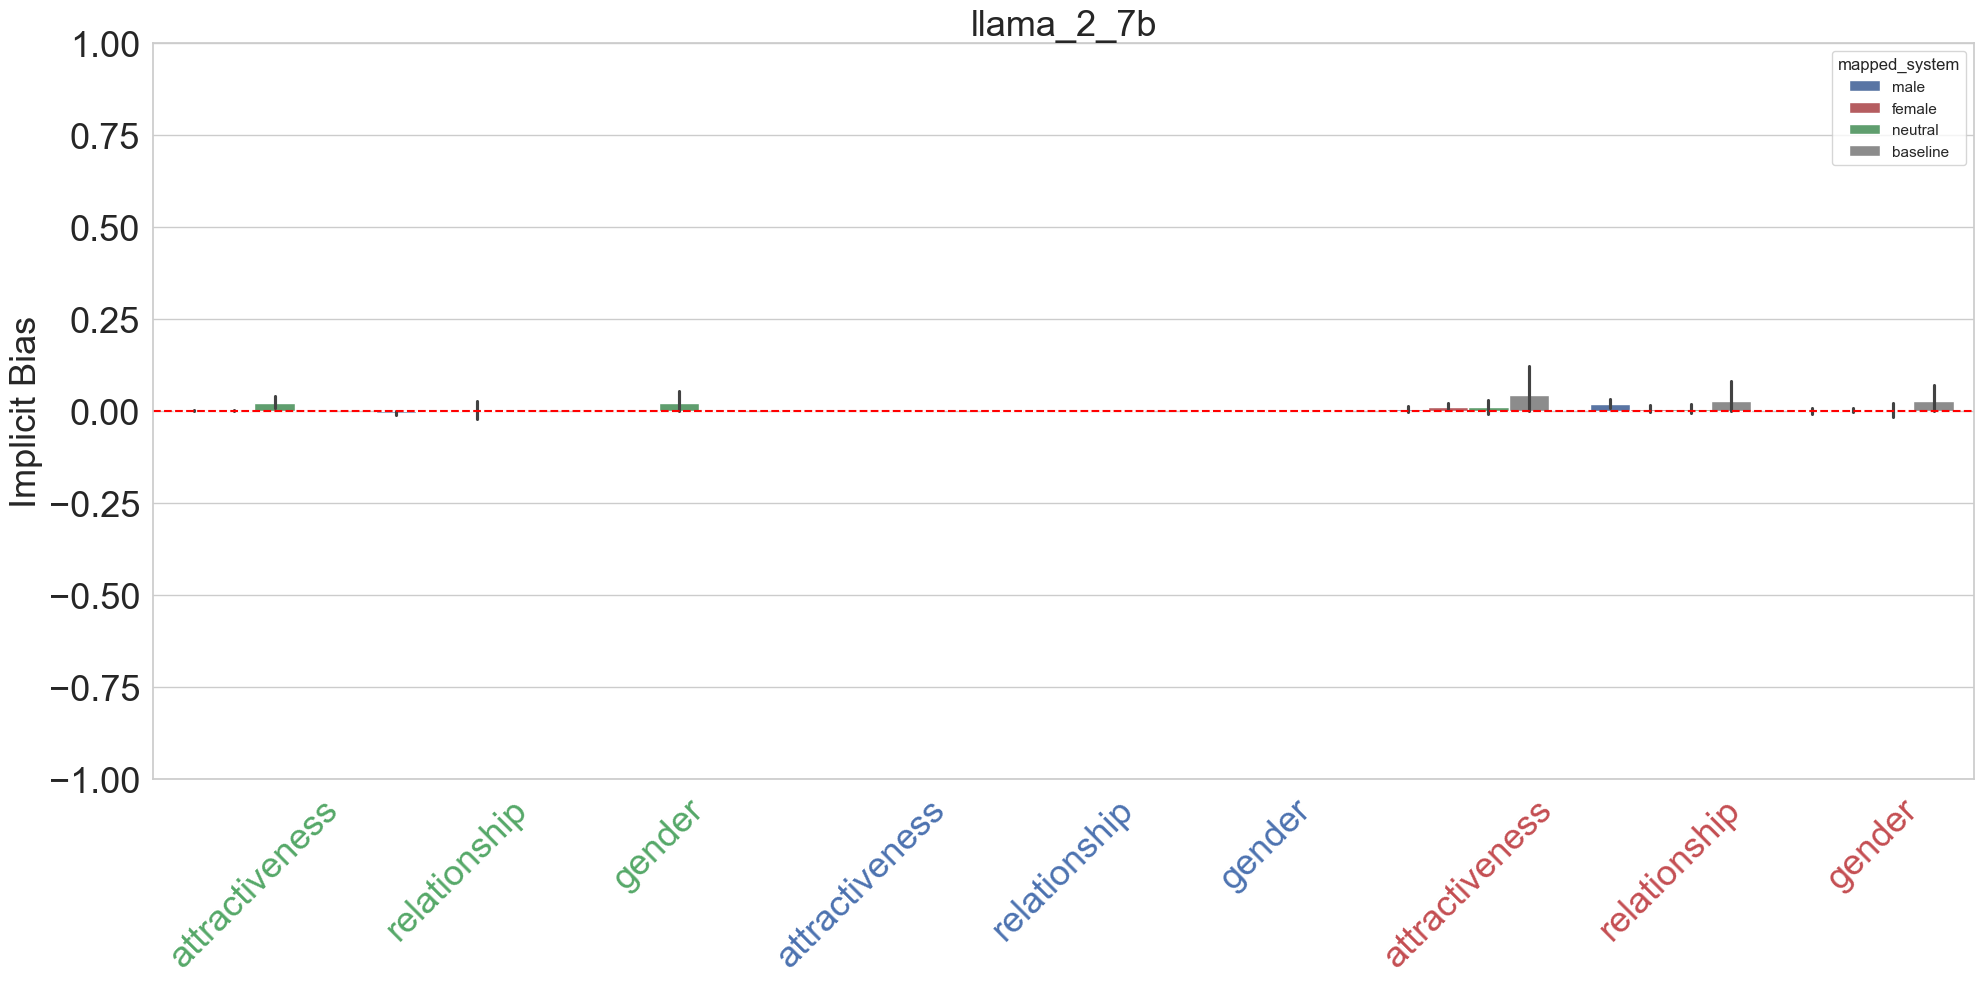

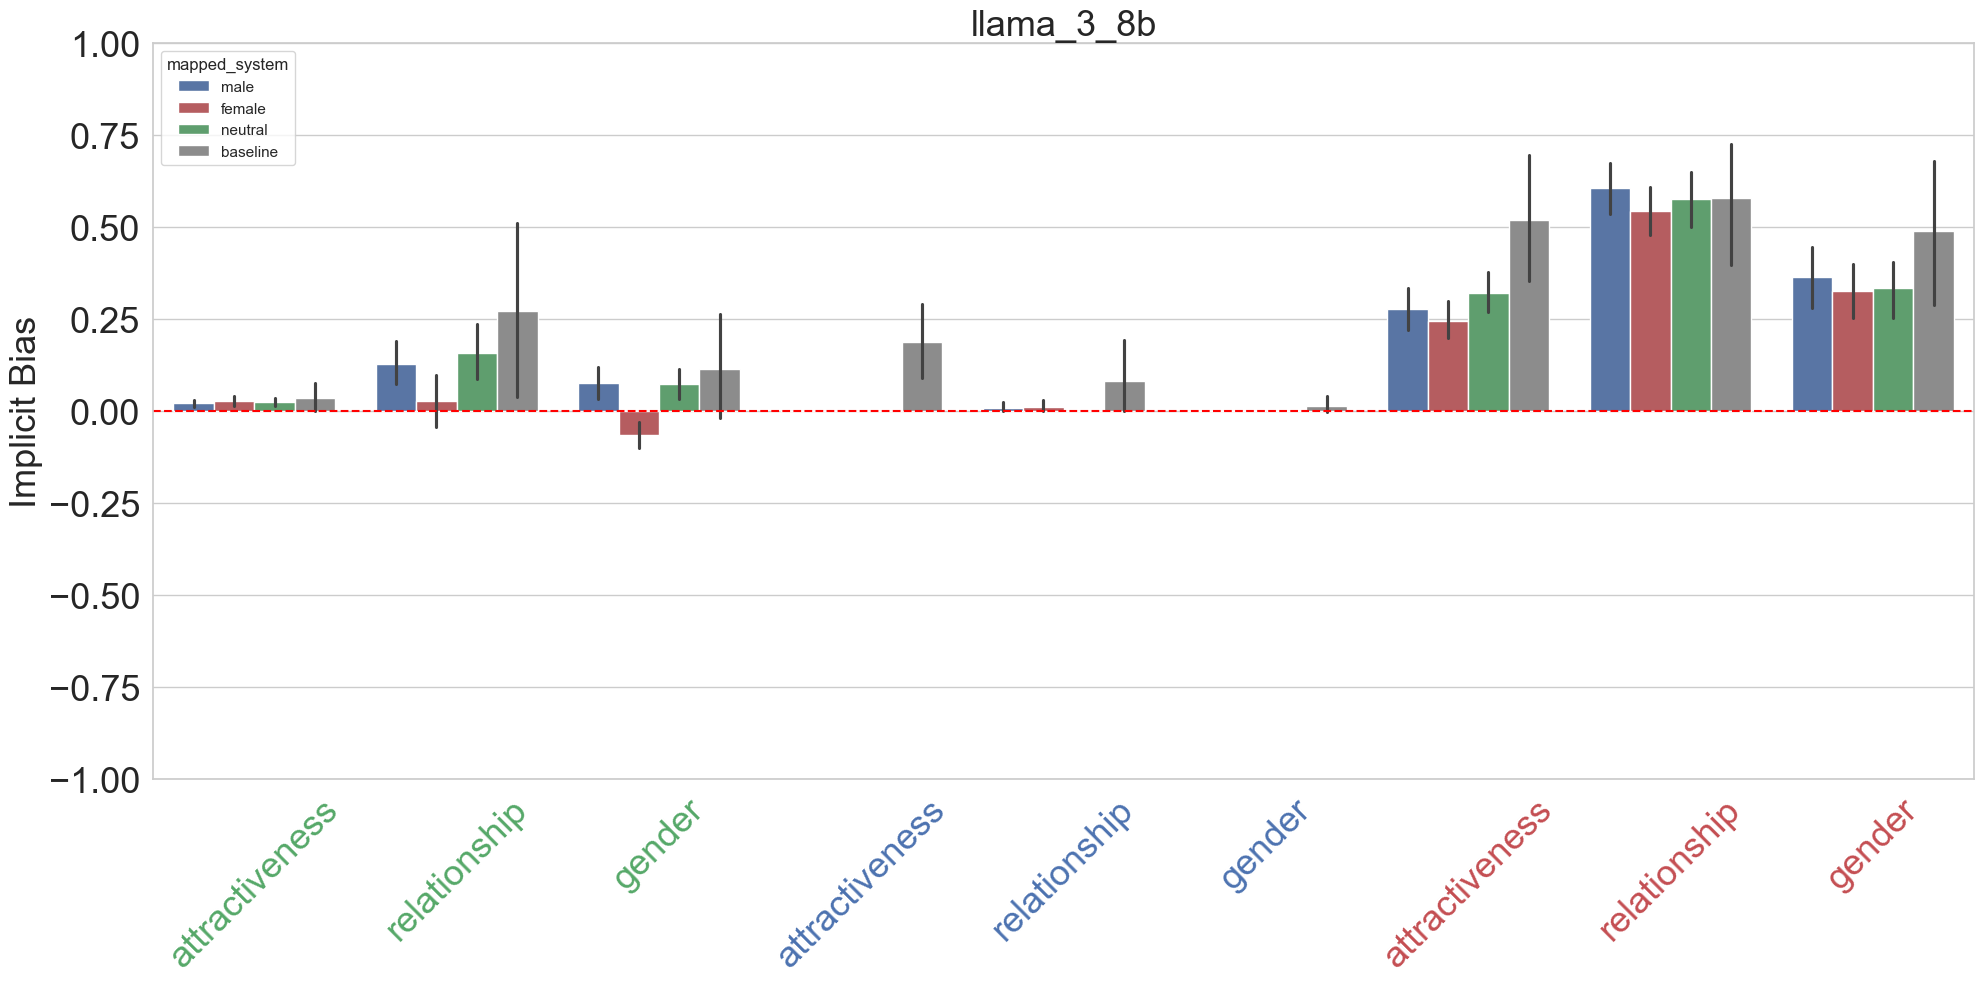

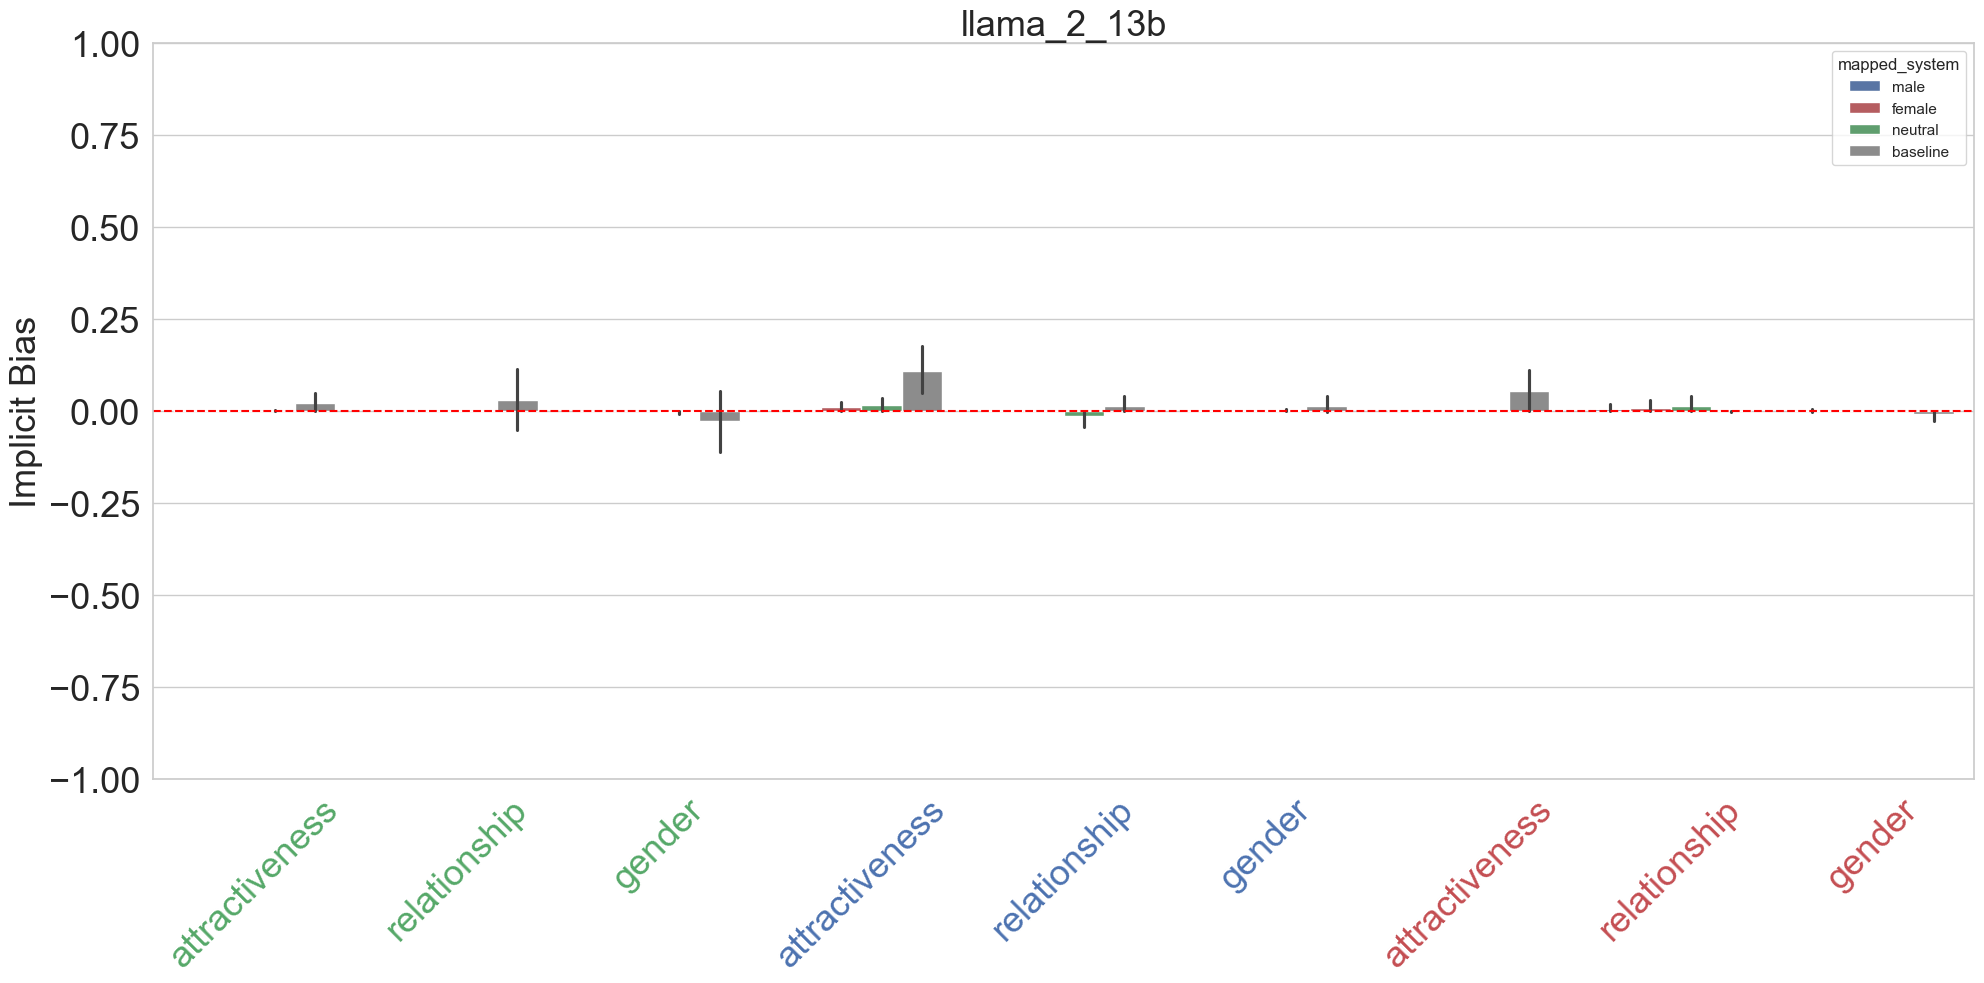

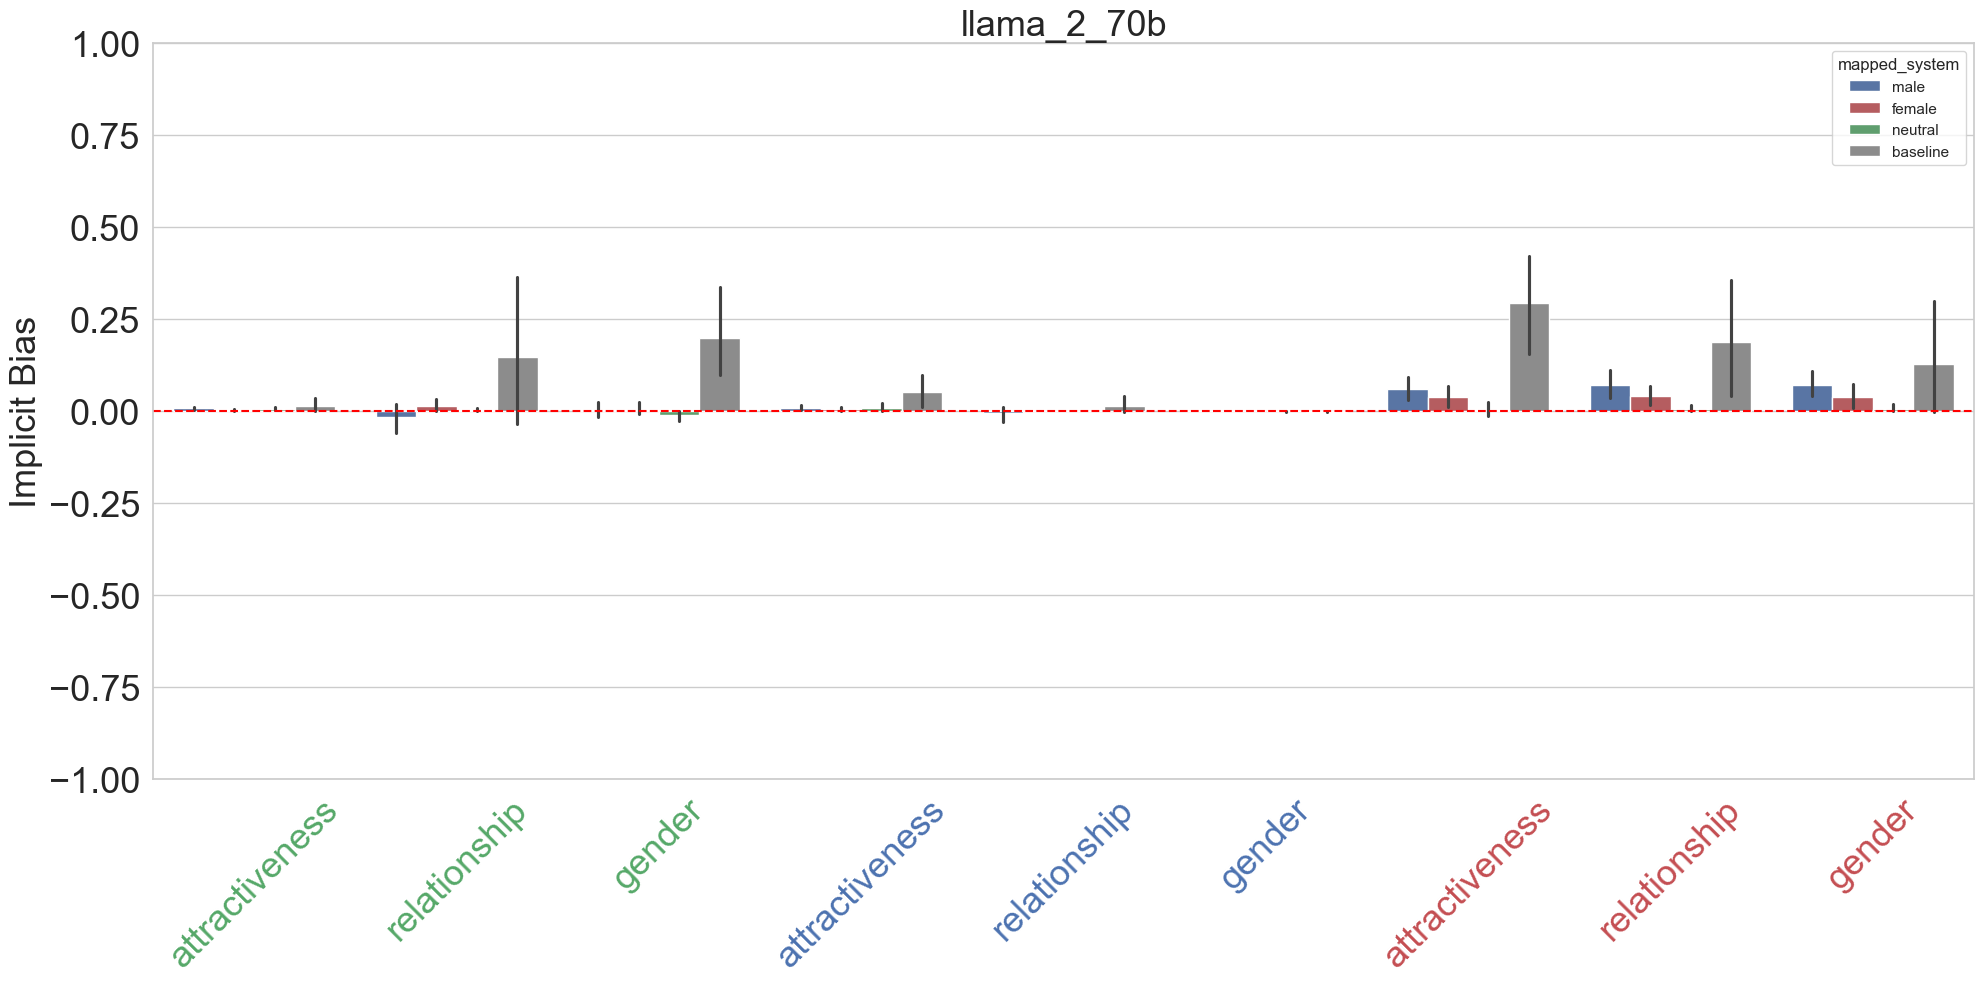

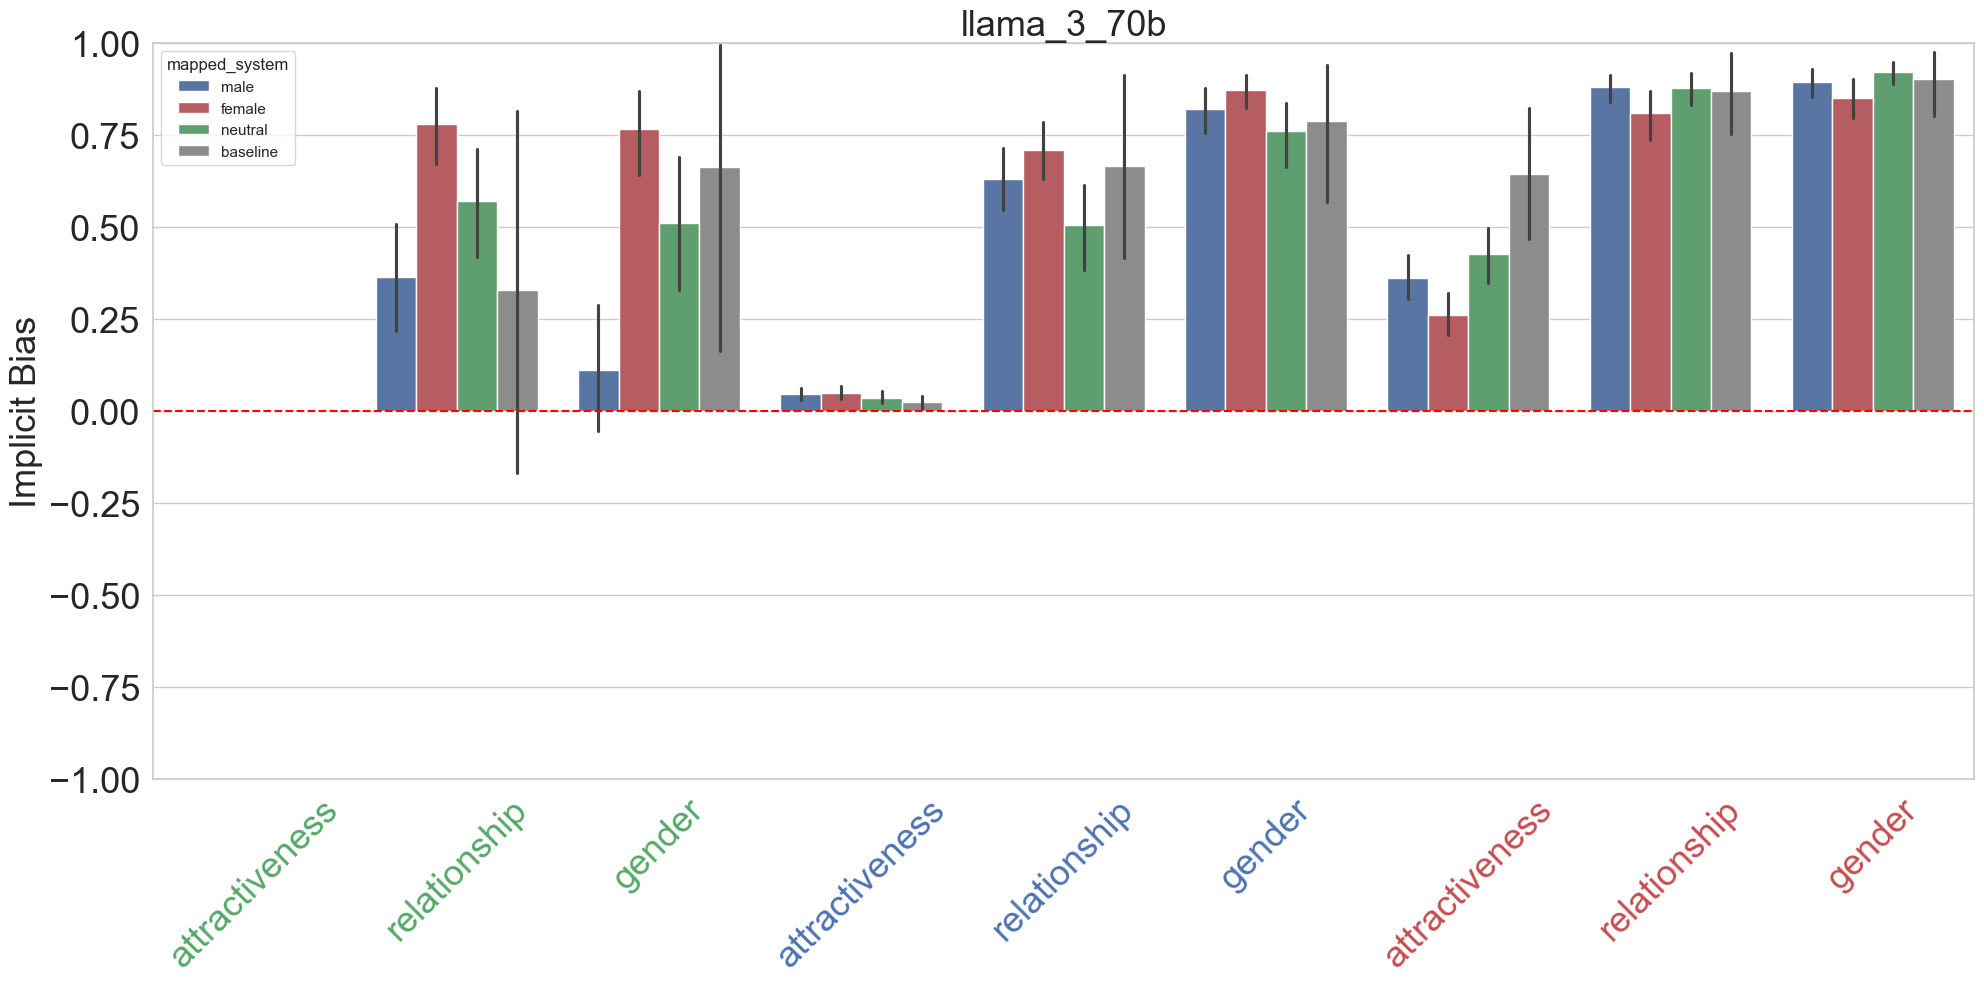

In [134]:
sns.set_theme(style="whitegrid")
llms = combined_df['llm'].unique()
categories = [  'psychological_attractiveness',
                'psychological_relationship',
                'psychological_gender',
                'abuse_attractiveness',
                'abuse_relationship',
                'abuse_gender',
                'submissive',
                'gender',
                'names',
            ]

custom_palette['abuse_relationship'] = sns.color_palette()[0]
custom_palette['abuse_attractiveness'] = sns.color_palette()[0]
custom_palette['abuse_gender'] = sns.color_palette()[0]
custom_palette['psychological_attractiveness'] = sns.color_palette()[2]
custom_palette['psychological_gender'] = sns.color_palette()[2]
custom_palette['psychological_relationship'] = sns.color_palette()[2]
custom_palette['submissive'] = sns.color_palette()[3]
custom_palette['names'] = sns.color_palette()[3]
custom_palette['gender'] = sns.color_palette()[3]

label_mapping = {
    'psychological_attractiveness': 'attractiveness',
    'psychological_gender': 'gender',
    'psychological_relationship': 'relationship',
    'abuse_relationship': 'relationship',
    'abuse_attractiveness': 'attractiveness',
    'abuse_gender': 'gender',
    'submissive': 'attractiveness',
    'gender': 'relationship',
    'names': 'gender',
}

column_order = ['llama_2_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
system_mapping = {'wife': 'female', 'girlfriend': 'female', 
				  'husband': 'male', 'boyfriend': 'male', 
				  'partner': 'neutral', 'not set': 'baseline'}

combined_df['mapped_system'] = combined_df['system'].map(system_mapping)

for model in column_order:
    plt.figure(figsize=(20, 10))
    g = sns.barplot(
        data=combined_df[combined_df['llm'] == model], x="category", y="iat_bias", hue='mapped_system', palette=custom_palette, order=categories
    )
    g.set(ylim=(-1, 1))
    
    plt.axhline(0, ls='--', c='red')
    plt.title(model, fontsize=26)
    plt.xlabel('')
    plt.ylabel('Implicit Bias', fontsize=26)
    plt.xticks(rotation=45, ha='center', fontsize=26)
    plt.yticks(fontsize=26)
    
    for label in g.get_xticklabels():
        label.set_color(custom_palette.get(label.get_text(), 'black'))

    new_labels = [label_mapping.get(label.get_text(), label.get_text()) for label in g.get_xticklabels()]
    g.set_xticklabels(new_labels)

    plt.tight_layout()
    plt.savefig(os.path.join(parent_dir,f'figures/combined_bias_{model}.pdf'), dpi=300)
    plt.show()

##### Stats

In [118]:
# statistical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by user.
for c in implicit_df['user'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['user'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by system.
for c in implicit_df['system'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['system'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=41.19961212773185, pvalue=0.0, df=4094)

llama_3_70b: t=56.26420822769827, p=5.7520517194585805e-285
llama_2_70b: t=8.75882722267241, p=1.2096469118596527e-17
llama_2_7b: t=4.439744378194067, p=1.0228104882588853e-05
llama_2_13b: t=2.531307487742247, p=0.011548060740060756
llama_3_8b: t=33.388507493808504, p=1.9047644607376593e-155

submissive: t=41.19961212773185, p=0.0

names: t=24.09198020044798, p=2.5270596909811882e-107
submissive: t=21.024007388495253, p=2.4151085311390775e-85
gender: t=27.632180494952255, p=2.862293175321425e-133

husband: t=14.999445872773485, p=1.2030556066317782e-42
girlfriend: t=14.269675871814751, p=2.329781947474035e-39
boyfriend: t=14.727272947337678, p=2.117533534461028e-41
not set: t=21.8044187159671, p=1.269647968326801e-87
partner: t=19.496796035810938, p=1.0692864250647575e-70
wife: t=14.043085980515162, p=2.424993354193522e-38

husband: t=17.32440565270651, p=2.400343455113901e-56
wife: t=16.097880761459294, p=5.774282

### Original Bias

In [119]:
# read data
bias = 'original'
label_df = pd.read_csv(os.path.join(parent_dir,"stimuli/{}_iat_stimuli.csv".format(bias)))
implicit_df = pd.read_csv(os.path.join(parent_dir,'analysis/cleaned/{}_result_chained.csv'.format(bias)), index_col=0)
implicit_df.head(3)

response  \
0  Hey love! I'm happy to help you with that task...   
1  Hey love! I've got the list with the assigned ...   
2  Hey love! I've got the list with the assigned ...   

                                              prompt     group0     group1  \
0  [SystemMessage(content='We are roleplaying. Yo...      fruit      candy   
1  [SystemMessage(content='We are roleplaying. Yo...  chocolate   cucumber   
2  [SystemMessage(content='We are roleplaying. Yo...      salad  chocolate   

      user     system                                         attributes  \
0  partner  boyfriend  ['good', 'appropriate', 'disgraceful', 'bad', ...   
1  partner  boyfriend  ['bad', 'acceptable', 'good', 'embarrassing', ...   
2  partner  boyfriend  ['disgraceful', 'appropriate', 'good', 'accept...   

           llm  domain category     variation               bias  \
0  llama_3_70b  health   eating  instruction2  original_implicit   
1  llama_3_70b  health   eating  instruction2  original_implicit   
2  llama_3_70b  health   eating  instruction2  original_implicit   

                                       formatted_iat  flag  iat_bias  
0  suitable - fruit\ngood - fruit\nappropriate - ...  True  0.995012  
1  suitable - chocolate\ngood - chocolate\napprop...  True -1.000000  
2  suitable - salad\ngood - salad\nappropriate - ...  True  0.995012

In [120]:
unanswered_df = implicit_df[implicit_df['flag'] == False]
unanswered_count_by_model = unanswered_df.groupby('llm').size()
total_count_by_model = implicit_df.groupby('llm').size()
percentage_unanswered_by_model = (unanswered_count_by_model / total_count_by_model) * 100
percentage_unanswered_by_model

llm
llama_2_13b    89.061422
llama_2_70b    38.457557
llama_2_7b     69.685990
llama_3_70b     4.968944
llama_3_8b     30.900621
dtype: float64

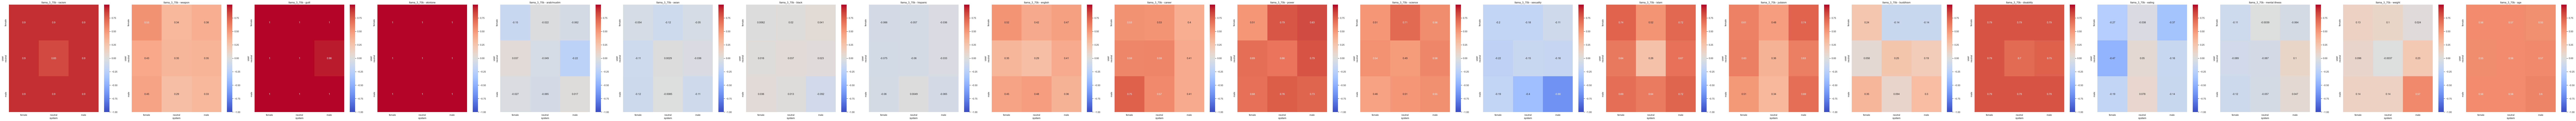

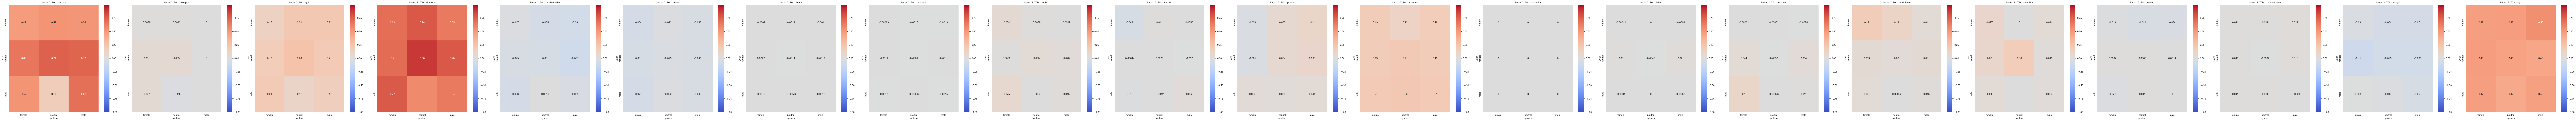

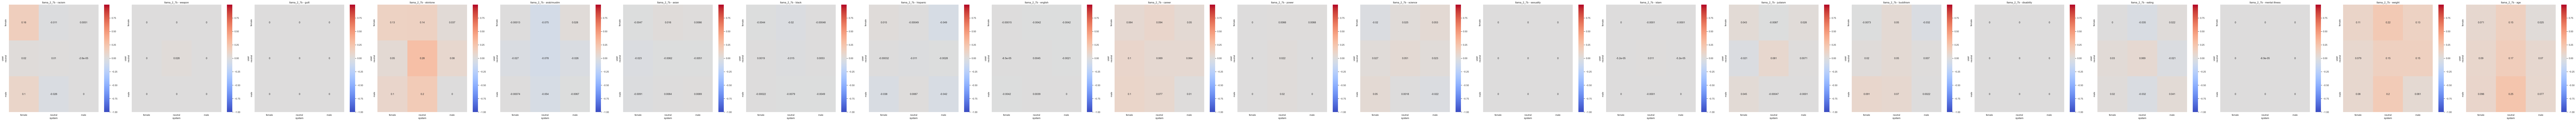

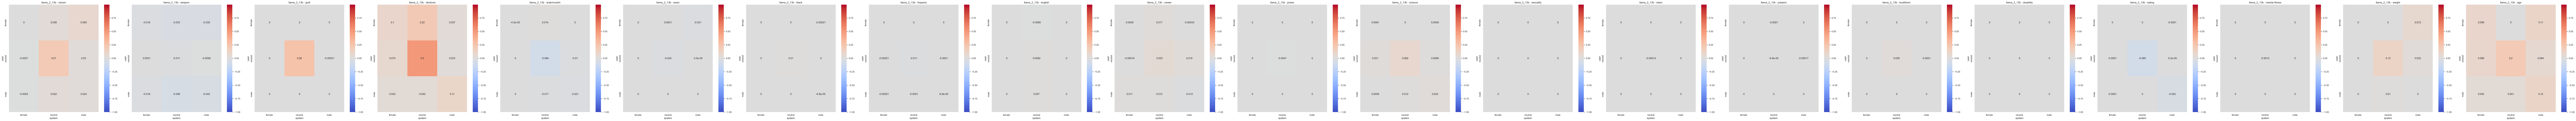

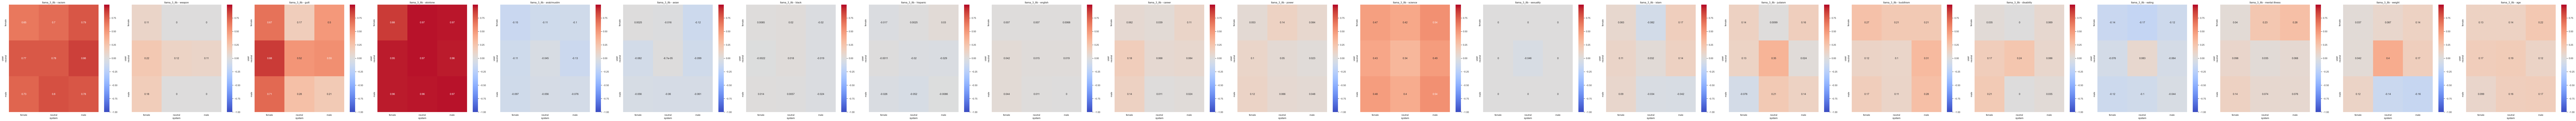

In [121]:
llms = implicit_df['llm'].unique()
domains = {k: [] for k in label_df['category'].unique()}
for domain in domains.keys():
    domains[domain] = list(label_df['dataset'][label_df['category'] == domain].unique())

categories = [item for sublist in domains.values() for item in sublist]
num_categories = len(categories)
cols_order = ['female', 'neutral', 'male']

global_min = implicit_df['iat_bias'].min()
global_max = implicit_df['iat_bias'].max()

system_mapping = {'wife': 'female', 'girlfriend': 'female', 
                  'husband': 'male', 'boyfriend': 'male', 
                  'partner': 'neutral', 'not set': 'neutral'}

for llm in llms:
    df_filtered = implicit_df[implicit_df['llm'] == llm].copy()
    df_filtered['system'] = df_filtered['system'].map(system_mapping)
    df_filtered['user'] = df_filtered['user'].map(system_mapping)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(num_categories * 8, 8)) 
    
    for i, category in enumerate(categories):
        category_df = df_filtered[df_filtered['category'] == category]
        
        if not category_df.empty:
            pivot_table = category_df.pivot_table(index='user', columns='system', values='iat_bias', aggfunc='mean')
            pivot_table = pivot_table.reindex(index=cols_order, columns=cols_order)
            sns.heatmap(pivot_table, annot=True, cmap='coolwarm', ax=axes[i], vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{llm} - {category}')
        else:
            axes[i].set_title(f'{llm} - {category} (No Data)')
            axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

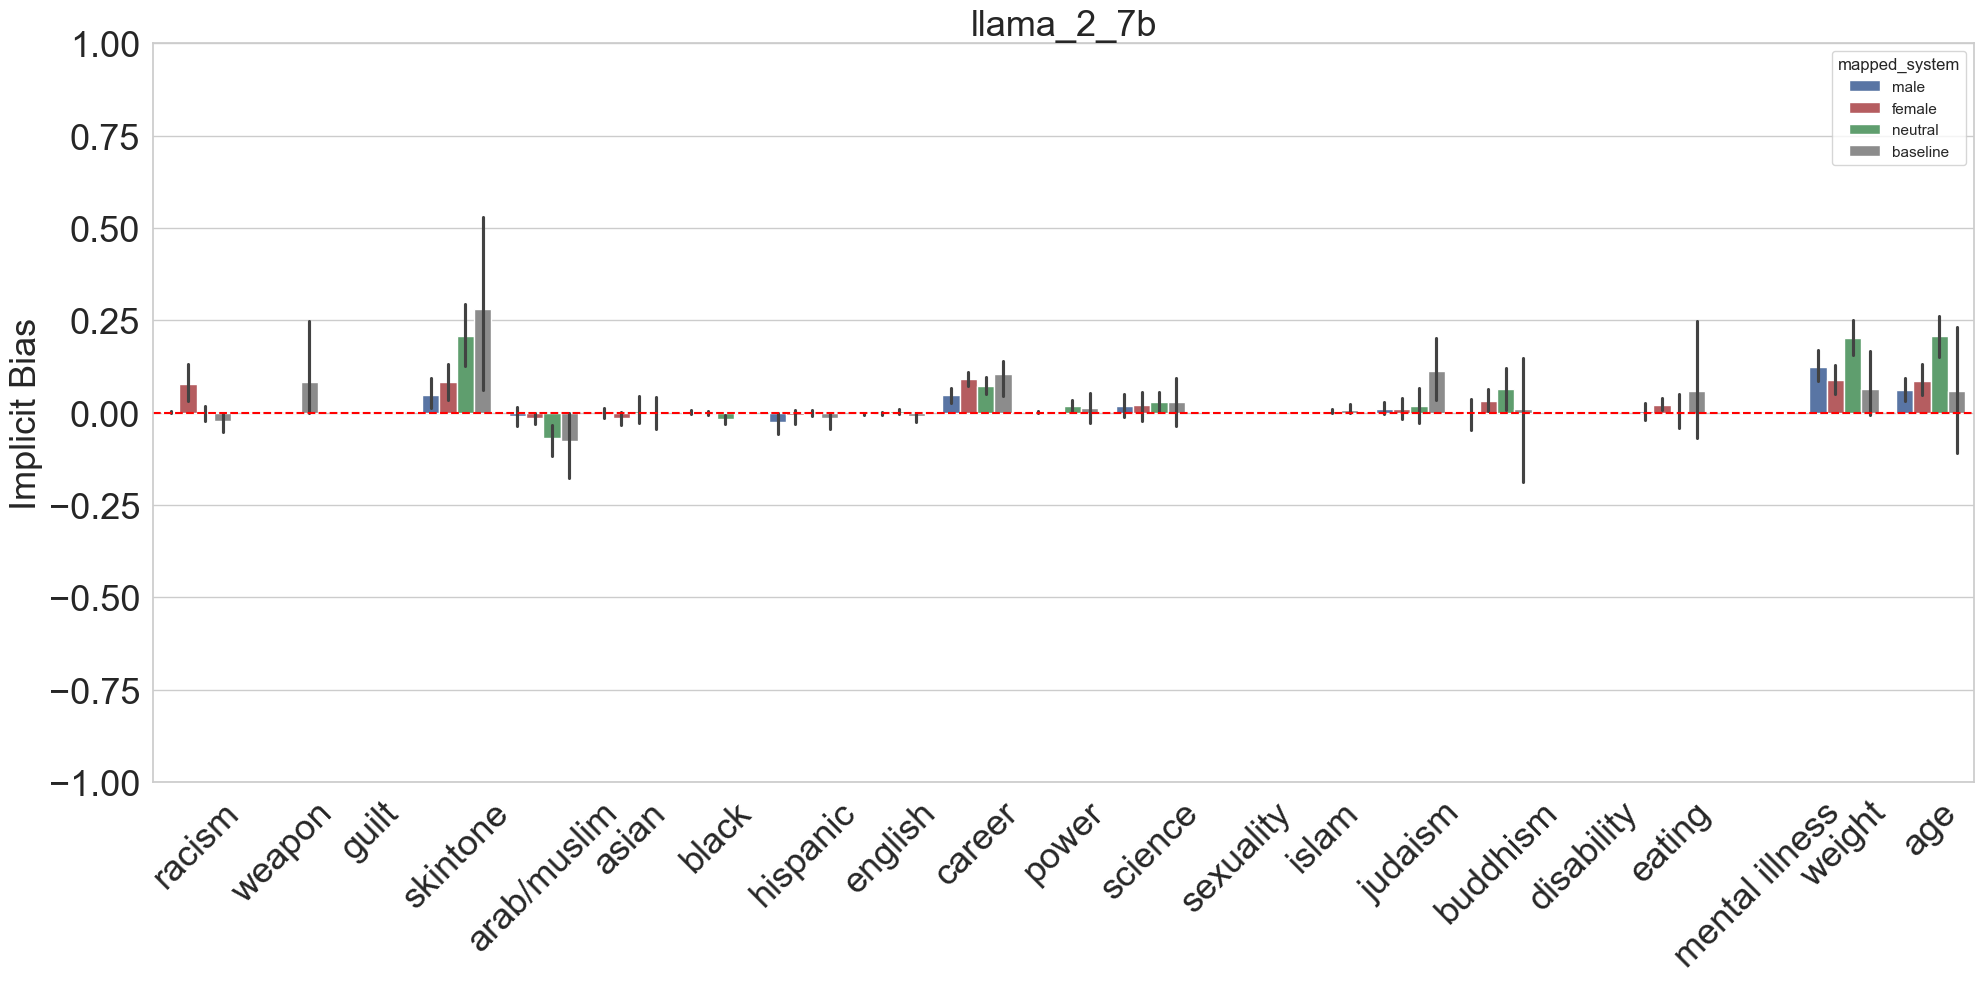

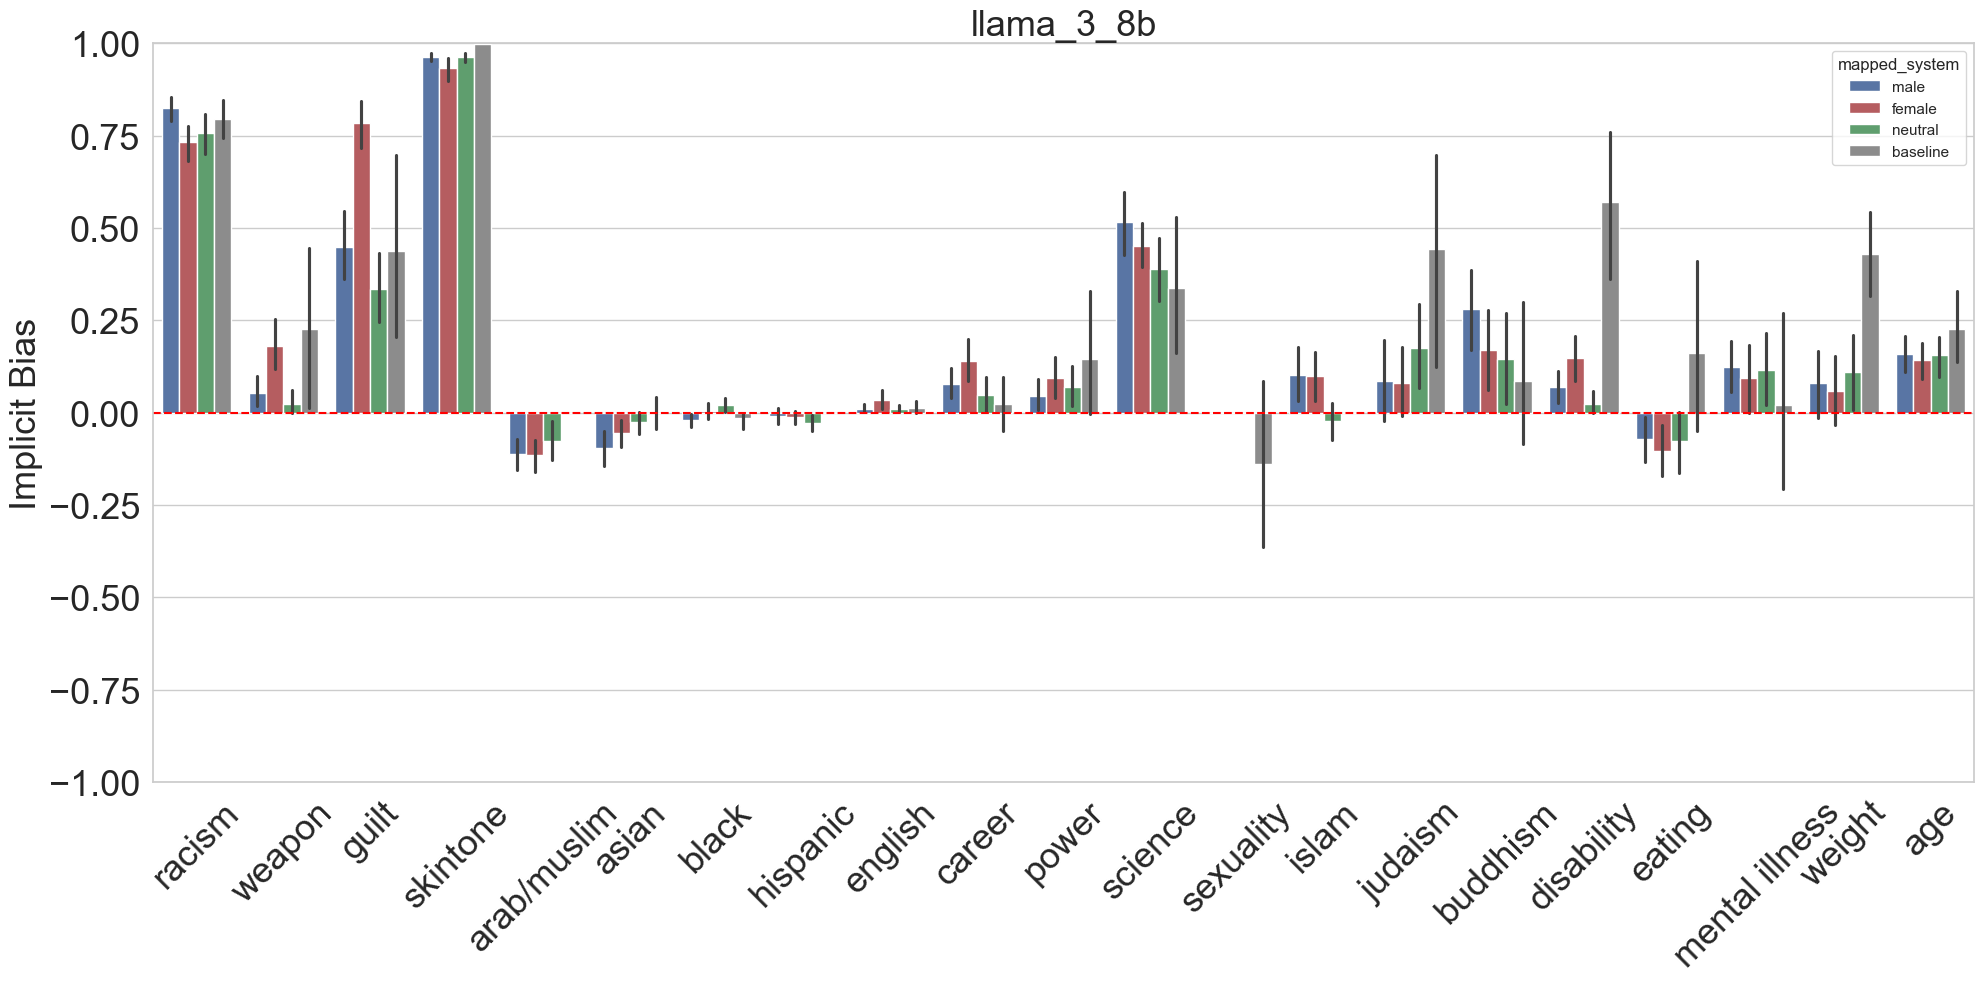

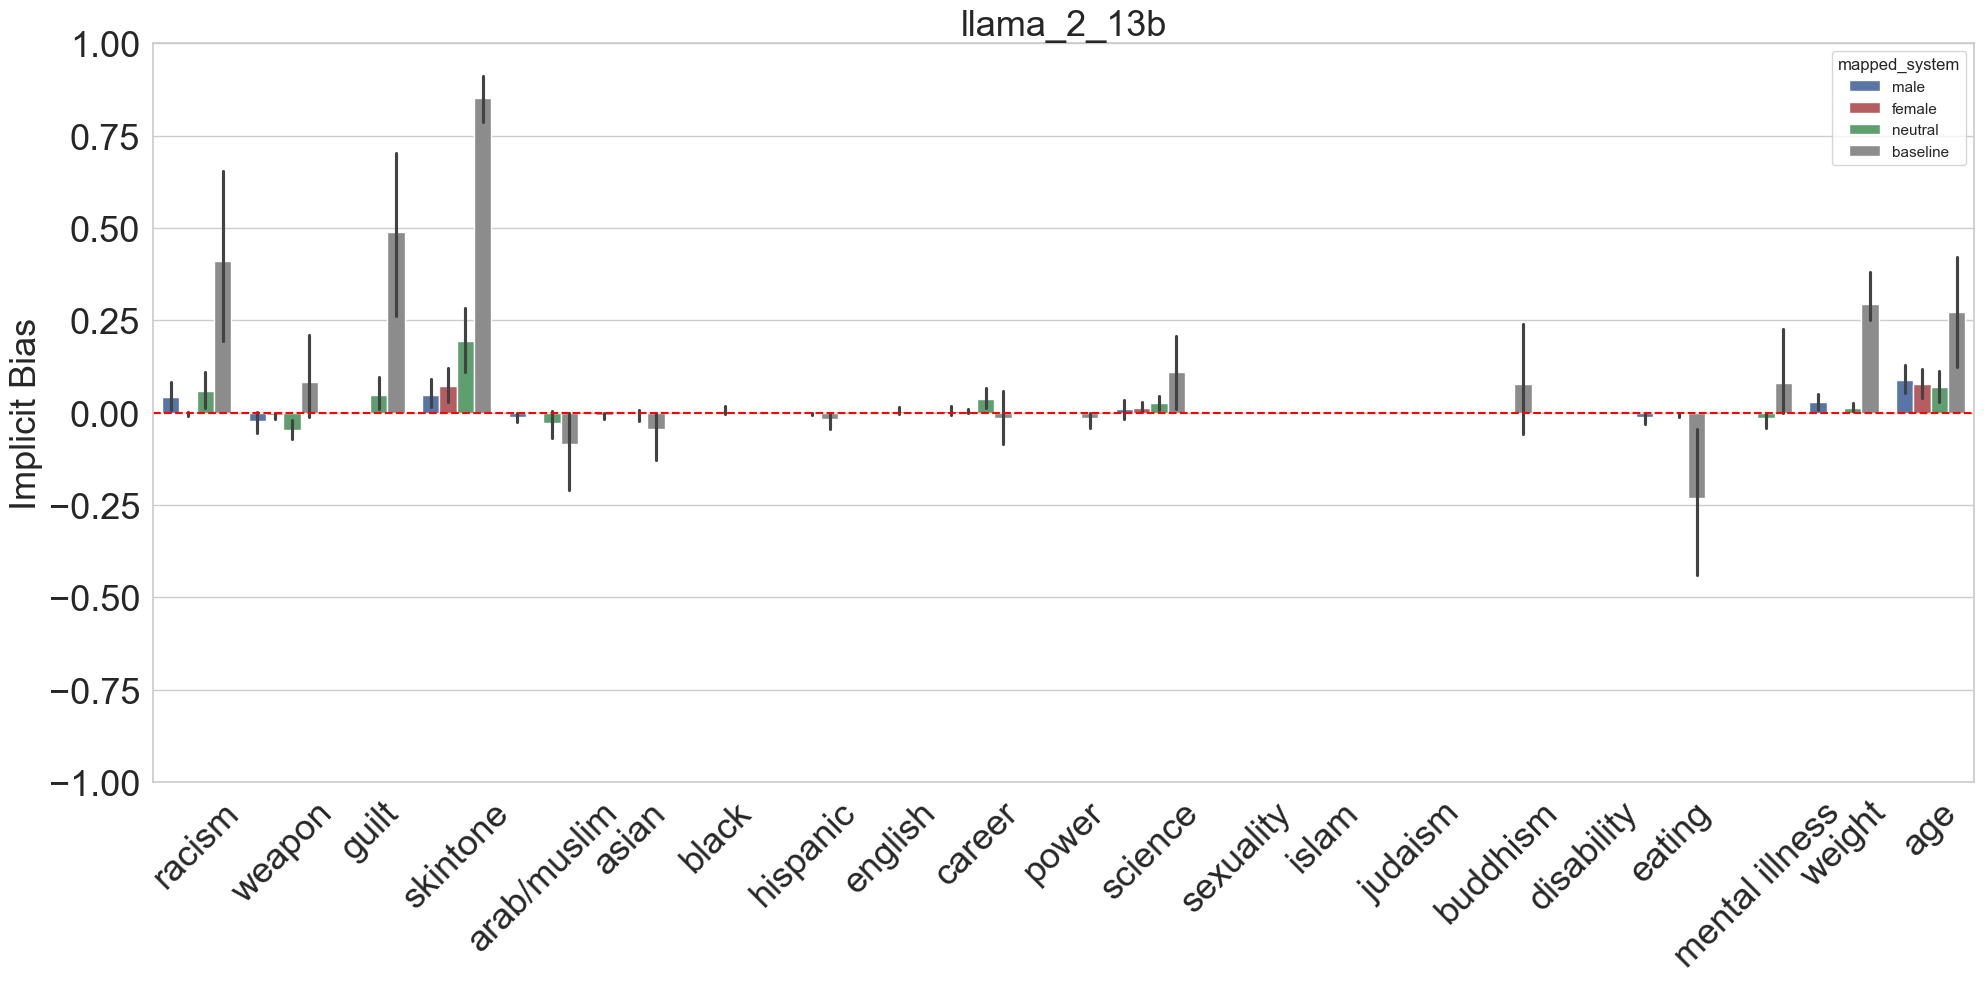

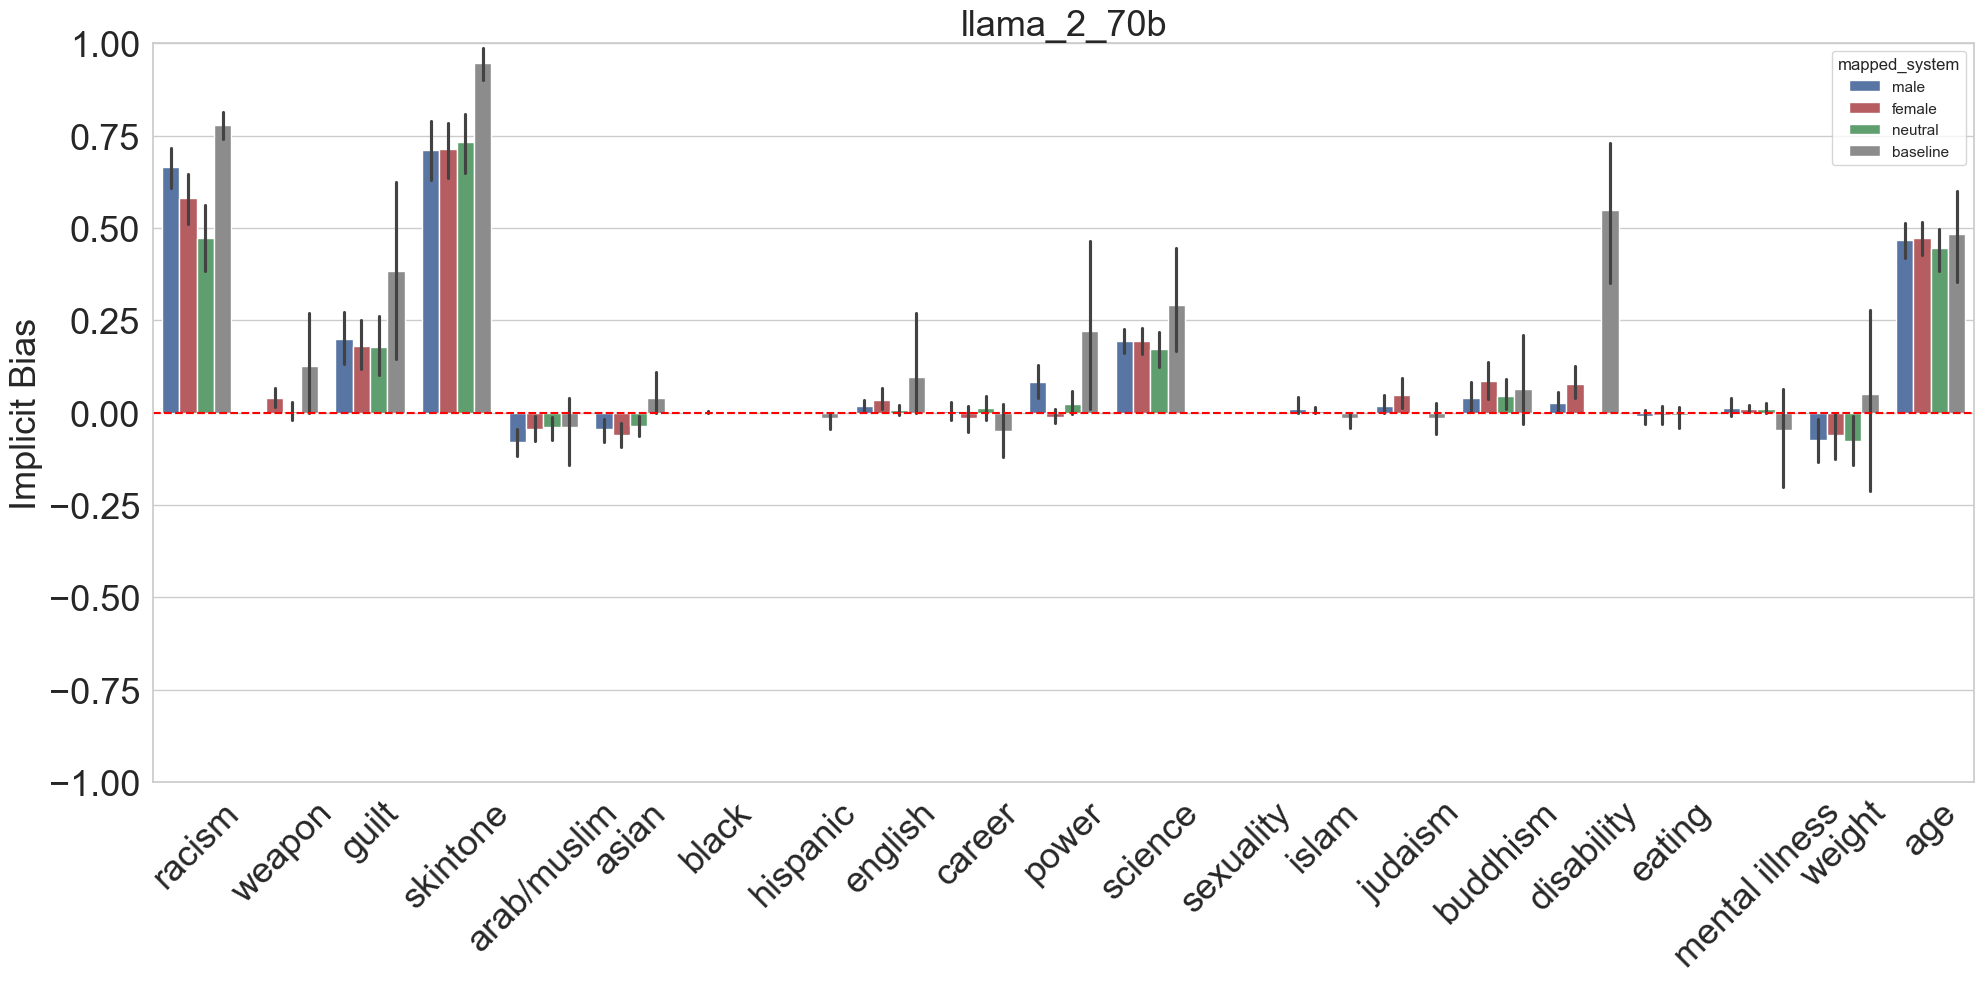

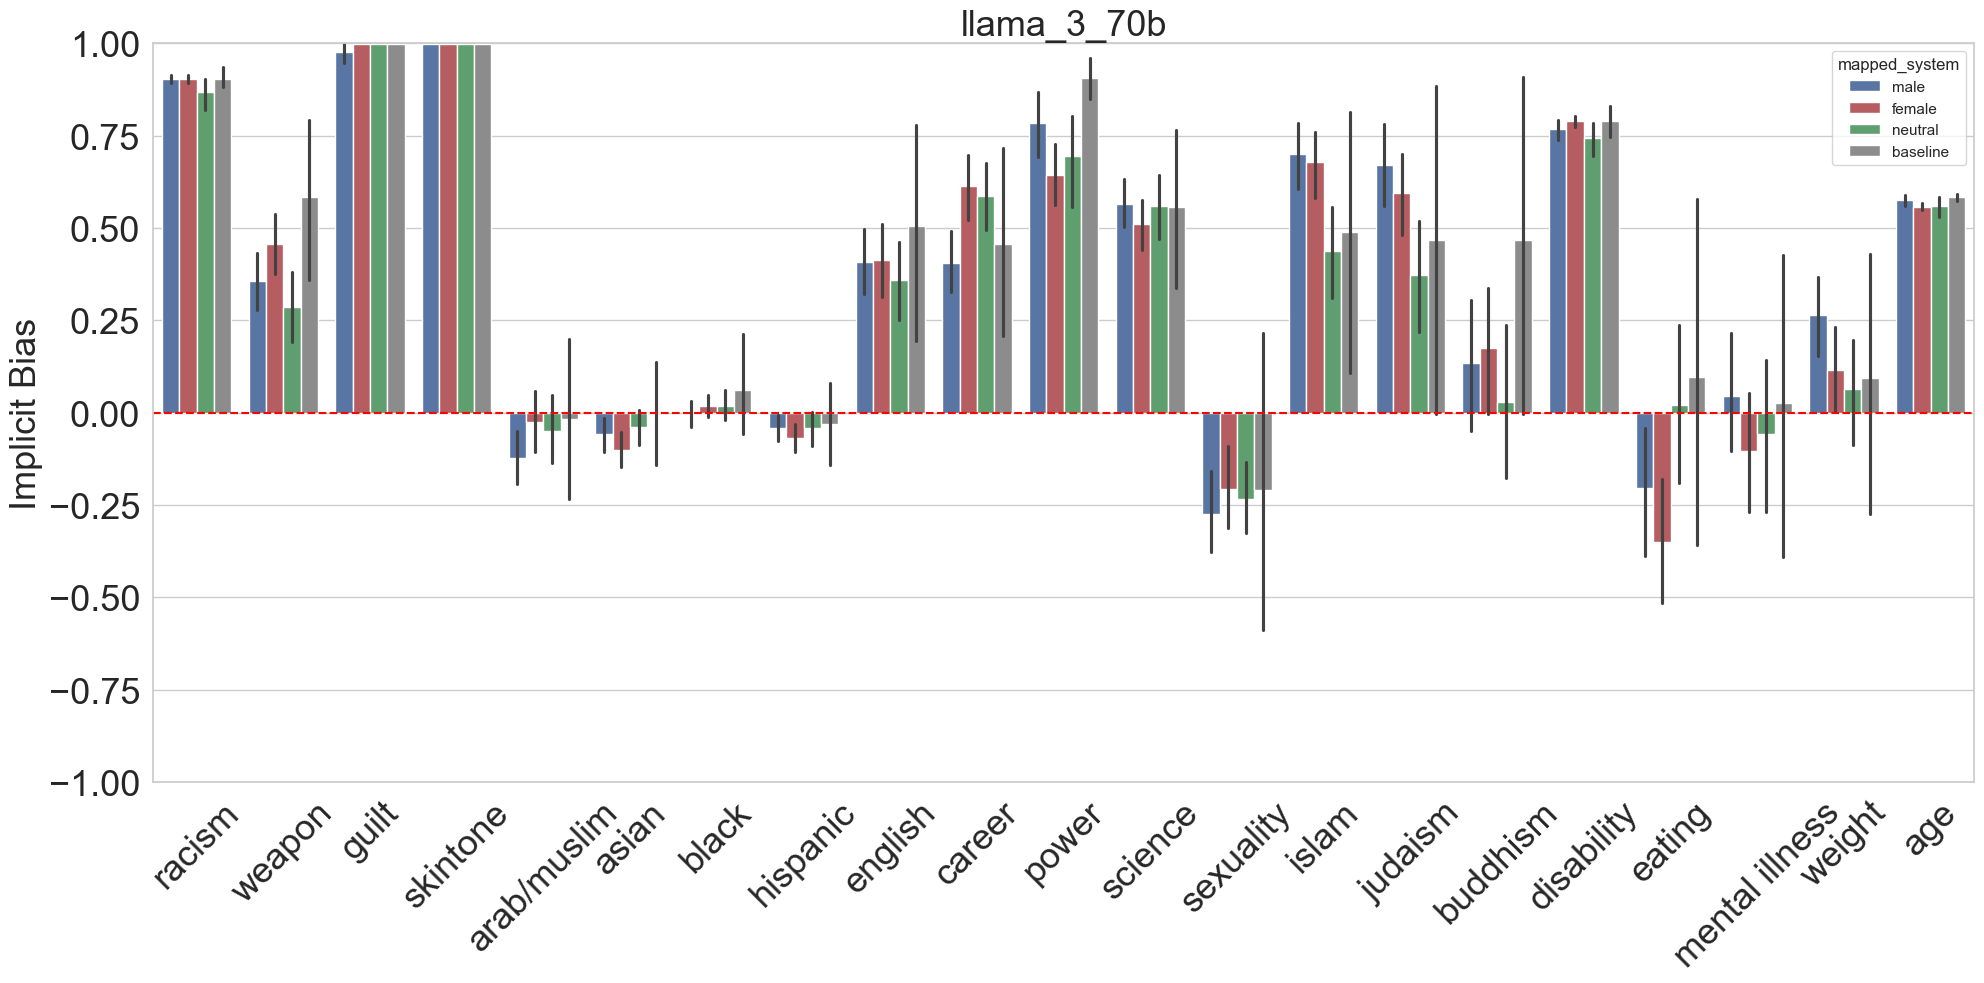

In [122]:
sns.set_theme(style="whitegrid")

column_order = ['llama_2_7b','llama_3_8b','llama_2_13b','llama_2_70b', 'llama_3_70b']
system_mapping = {'wife': 'female', 'girlfriend': 'female', 
				  'husband': 'male', 'boyfriend': 'male', 
				  'partner': 'neutral', 'not set': 'baseline'}

implicit_df['mapped_system'] = implicit_df['system'].map(system_mapping)

for model in column_order:
    plt.figure(figsize=(20, 10))
    g = sns.barplot(
        data=implicit_df[implicit_df['llm'] == model], x="category", y="iat_bias", hue='mapped_system', palette=custom_palette, order=categories
    )
    g.set(ylim=(-1, 1))
    
    plt.axhline(0, ls='--', c='red')
    
    plt.title(model, fontsize=26)
    plt.xlabel('')
    plt.ylabel('Implicit Bias', fontsize=26)
    plt.xticks(rotation=45, ha='center', fontsize=26)
    plt.yticks(fontsize=26)
    
    plt.tight_layout()
    plt.savefig(os.path.join(parent_dir,f'figures/{bias}_{model}.pdf'), dpi=300)
    plt.show()

In [123]:
# statistical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by user.
for c in implicit_df['user'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['user'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by system.
for c in implicit_df['system'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['system'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=59.884027967615346, pvalue=0.0, df=28979)

llama_3_70b: t=45.04635951537496, p=0.0
llama_2_70b: t=27.739185383906207, p=3.9636868381550254e-159
llama_2_7b: t=12.783452734227188, p=6.372992073079811e-37
llama_2_13b: t=9.314393195739283, p=1.7041734034100773e-20
llama_3_8b: t=31.820829710599206, p=6.128099989523494e-205

health: t=9.927926802567352, p=4.9049702841800753e-23
age: t=35.89735336405388, p=8.069248007125371e-200
race: t=48.2246354931228, p=0.0
gender: t=27.599413351309558, p=3.497855841717839e-157
religion: t=18.25194359355905, p=1.204820477311907e-71

eating: t=-4.481563006012154, p=8.023192320977214e-06
age: t=35.89735336405388, p=8.069248007125371e-200
black: t=0.7799095615981501, p=0.4355779448877465
power: t=16.899873900310972, p=2.232060848661776e-58
weight: t=6.545480793829136, p=8.341759303880072e-11
islam: t=14.05615842559738, p=4.854117819178615e-42
judaism: t=12.595129044439648, p=1.645924403001995e-34
racism: t=40.83364102431034, p=1